In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import PGD, FGSM
import matplotlib.pyplot as plt


from src.models  import CifarResNet, MNIST_CNN, CIFAR_CNN
from src.helpers import evaluate_rob_accuracy, evaluate_clean_accuracy, load_model, safe_model,_evaluate_model
from src.data_loader import load_torchvision_dataset, load_imagenette
#from src.pruning import identify_layers, _evaluate_sparsity

import time

if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)
dtype = torch.float32

cuda:0


In [2]:
def PGD(model, data_loader, criterion, steps, max_stepsize, eps, device):
    model.eval()
    advs = []
    correct = 0
    total = 0
    for i, data in enumerate(data_loader):
        if i == i:
            inputs, labels = data
            inputs, labels =inputs.to(device), labels.to(device)

            adv_examples = inputs
            adv_examples.requires_grad = True
            adv_examples.retain_grad()
            for step in range(steps):
                #print(torch.max(adv_examples[0]-inputs[0][0]))
                adv_examples, pert = FGSM_step(model, adv_examples, labels, criterion, max_stepsize, device)
                pert = adv_examples - inputs
                pert.clamp_(-eps, eps)
                adv_examples = inputs + pert
                adv_examples.clamp_(0,1)
            advs.append(adv_examples)
            preds = model(adv_examples)
            #pred_labels = 
            _, predicted = torch.max(preds.data, 1)
            total += len(predicted)
            #correct += (pred_labels == labels).sum().item()
            correct += (predicted != labels).sum().item()
    return advs, correct/total
        

def FGSM_step(model, inputs, labels, criterion, eps, device):

    inputs.retain_grad()
    perturbation = torch.zeros_like(inputs).to(device)
    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward(retain_graph=True)
    perturbation = torch.sign(inputs.grad).clamp_(-eps, eps)
    adv_examples = inputs + perturbation
    adv_examples.clamp_(0,1)
    return adv_examples, perturbation
    

def FGSM(model, data_loader, criterion, eps, device):
    model.eval()
    #mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
    #mean = torch.tensor(mean).view(3,1,1).expand(3,32,32).to(device)
    #std = torch.tensor(std).view(3,1,1).expand(3,32,32).to(device)
    advs = []
    correct = 0
    total = 0
    for i,data in enumerate(data_loader):
        if i < 10:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs.requires_grad = True
            adv_examples, perturbation = FGSM_step(model, inputs, labels, criterion, eps, device)

            advs.append(adv_examples)
            preds = model(adv_examples)
            #pred_labels = 
            _, predicted = torch.max(preds.data, 1)
            total += len(predicted)
            #correct += (pred_labels == labels).sum().item()
            correct += (predicted != labels).sum().item()

    
    return advs, correct/total

In [3]:
model = CifarResNet()
model.to(device)
train_loader, test_loader = load_torchvision_dataset('CIFAR10', data_augmentation=True, batchsize = 128)

identifying layers
Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_stats = model.fit_fast(train_loader, test_loader, 100, device)

fast adversarial training
[1,     1] loss: 6.34407, adv_train_accuracy: 0.00, clean_train_accuracy : 21.88
[1,     6] loss: 7.53927, adv_train_accuracy: 1.56, clean_train_accuracy : 18.75
[1,    11] loss: 5.54230, adv_train_accuracy: 0.78, clean_train_accuracy : 21.09
[1,    16] loss: 5.79157, adv_train_accuracy: 2.34, clean_train_accuracy : 17.19
[1,    21] loss: 3.86754, adv_train_accuracy: 0.00, clean_train_accuracy : 28.91
[1,    26] loss: 4.53703, adv_train_accuracy: 3.12, clean_train_accuracy : 29.69
[1,    31] loss: 3.54979, adv_train_accuracy: 10.94, clean_train_accuracy : 26.56
[1,    36] loss: 3.67652, adv_train_accuracy: 2.34, clean_train_accuracy : 30.47
[1,    41] loss: 2.88522, adv_train_accuracy: 3.91, clean_train_accuracy : 29.69
[1,    46] loss: 3.28745, adv_train_accuracy: 5.47, clean_train_accuracy : 27.34
[1,    51] loss: 3.17829, adv_train_accuracy: 2.34, clean_train_accuracy : 26.56
[1,    56] loss: 3.11140, adv_train_accuracy: 5.47, clean_train_accuracy : 35.94
[

[2,    96] loss: 2.11467, adv_train_accuracy: 20.31, clean_train_accuracy : 37.50
[2,   101] loss: 2.20399, adv_train_accuracy: 14.84, clean_train_accuracy : 41.41
[2,   106] loss: 2.23154, adv_train_accuracy: 14.06, clean_train_accuracy : 39.06
[2,   111] loss: 2.26911, adv_train_accuracy: 14.84, clean_train_accuracy : 35.94
[2,   116] loss: 2.28699, adv_train_accuracy: 14.84, clean_train_accuracy : 39.06
[2,   121] loss: 2.24878, adv_train_accuracy: 15.62, clean_train_accuracy : 39.06
[2,   126] loss: 2.24568, adv_train_accuracy: 14.06, clean_train_accuracy : 38.28
[2,   131] loss: 2.24971, adv_train_accuracy: 17.19, clean_train_accuracy : 39.06
[2,   136] loss: 2.11296, adv_train_accuracy: 25.00, clean_train_accuracy : 39.06
[2,   141] loss: 2.14763, adv_train_accuracy: 16.41, clean_train_accuracy : 38.28
[2,   146] loss: 2.23212, adv_train_accuracy: 16.41, clean_train_accuracy : 36.72
[2,   151] loss: 2.10620, adv_train_accuracy: 20.31, clean_train_accuracy : 40.62
[2,   156] loss:

[3,   191] loss: 2.19539, adv_train_accuracy: 17.97, clean_train_accuracy : 33.59
[3,   196] loss: 2.12426, adv_train_accuracy: 19.53, clean_train_accuracy : 43.75
[3,   201] loss: 2.06596, adv_train_accuracy: 18.75, clean_train_accuracy : 42.97
[3,   206] loss: 2.17825, adv_train_accuracy: 14.06, clean_train_accuracy : 42.97
[3,   211] loss: 2.09233, adv_train_accuracy: 22.66, clean_train_accuracy : 38.28
[3,   216] loss: 2.11139, adv_train_accuracy: 22.66, clean_train_accuracy : 35.94
[3,   221] loss: 2.04660, adv_train_accuracy: 25.00, clean_train_accuracy : 41.41
[3,   226] loss: 2.11679, adv_train_accuracy: 16.41, clean_train_accuracy : 39.84
[3,   231] loss: 2.05175, adv_train_accuracy: 25.00, clean_train_accuracy : 41.41
[3,   236] loss: 2.16914, adv_train_accuracy: 17.19, clean_train_accuracy : 32.03
[3,   241] loss: 2.18449, adv_train_accuracy: 16.41, clean_train_accuracy : 35.94
[3,   246] loss: 2.10642, adv_train_accuracy: 17.19, clean_train_accuracy : 38.28
[3,   251] loss:

[4,   286] loss: 2.18528, adv_train_accuracy: 14.84, clean_train_accuracy : 38.28
[4,   291] loss: 2.10498, adv_train_accuracy: 22.66, clean_train_accuracy : 40.62
[4,   296] loss: 2.19851, adv_train_accuracy: 17.19, clean_train_accuracy : 35.16
[4,   301] loss: 2.19311, adv_train_accuracy: 14.84, clean_train_accuracy : 38.28
[4,   306] loss: 2.05725, adv_train_accuracy: 22.66, clean_train_accuracy : 45.31
[4,   311] loss: 2.00488, adv_train_accuracy: 26.56, clean_train_accuracy : 41.41
[4,   316] loss: 2.00208, adv_train_accuracy: 28.12, clean_train_accuracy : 44.53
[4,   321] loss: 2.03873, adv_train_accuracy: 26.56, clean_train_accuracy : 42.19
[4,   326] loss: 2.13465, adv_train_accuracy: 17.97, clean_train_accuracy : 35.94
[4,   331] loss: 2.16525, adv_train_accuracy: 18.75, clean_train_accuracy : 39.06
[4,   336] loss: 2.15825, adv_train_accuracy: 19.53, clean_train_accuracy : 32.81
[4,   341] loss: 2.12856, adv_train_accuracy: 20.31, clean_train_accuracy : 42.19
[4,   346] loss:

[5,   381] loss: 1.96447, adv_train_accuracy: 25.00, clean_train_accuracy : 45.31
[5,   386] loss: 2.06703, adv_train_accuracy: 22.66, clean_train_accuracy : 48.44
[5,   391] loss: 1.96978, adv_train_accuracy: 26.25, clean_train_accuracy : 51.25
fgsm robustness: 0.224609375
pgd robustness: 0.22265625
duration: 121 s - train loss: 2.09664 - train accuracy: 21.00 - validation loss: 1.78398 - validation accuracy: 34.87 
[6,     1] loss: 1.96700, adv_train_accuracy: 29.69, clean_train_accuracy : 44.53
[6,     6] loss: 2.11167, adv_train_accuracy: 17.97, clean_train_accuracy : 39.84
[6,    11] loss: 2.13172, adv_train_accuracy: 15.62, clean_train_accuracy : 46.88
[6,    16] loss: 1.98190, adv_train_accuracy: 21.09, clean_train_accuracy : 43.75
[6,    21] loss: 2.02814, adv_train_accuracy: 26.56, clean_train_accuracy : 41.41
[6,    26] loss: 2.10224, adv_train_accuracy: 17.19, clean_train_accuracy : 42.97
[6,    31] loss: 2.06979, adv_train_accuracy: 26.56, clean_train_accuracy : 42.97
[6,  

[7,    71] loss: 2.03851, adv_train_accuracy: 23.44, clean_train_accuracy : 41.41
[7,    76] loss: 2.07485, adv_train_accuracy: 21.09, clean_train_accuracy : 39.84
[7,    81] loss: 2.09404, adv_train_accuracy: 20.31, clean_train_accuracy : 39.84
[7,    86] loss: 2.10279, adv_train_accuracy: 19.53, clean_train_accuracy : 40.62
[7,    91] loss: 1.91337, adv_train_accuracy: 28.12, clean_train_accuracy : 52.34
[7,    96] loss: 2.09869, adv_train_accuracy: 22.66, clean_train_accuracy : 42.97
[7,   101] loss: 2.01159, adv_train_accuracy: 25.78, clean_train_accuracy : 44.53
[7,   106] loss: 2.16211, adv_train_accuracy: 17.97, clean_train_accuracy : 36.72
[7,   111] loss: 1.97383, adv_train_accuracy: 22.66, clean_train_accuracy : 38.28
[7,   116] loss: 2.08495, adv_train_accuracy: 27.34, clean_train_accuracy : 46.09
[7,   121] loss: 2.12922, adv_train_accuracy: 19.53, clean_train_accuracy : 38.28
[7,   126] loss: 2.02069, adv_train_accuracy: 25.78, clean_train_accuracy : 46.09
[7,   131] loss:

[8,   166] loss: 2.06899, adv_train_accuracy: 24.22, clean_train_accuracy : 37.50
[8,   171] loss: 2.10176, adv_train_accuracy: 23.44, clean_train_accuracy : 46.09
[8,   176] loss: 2.02928, adv_train_accuracy: 20.31, clean_train_accuracy : 39.84
[8,   181] loss: 2.01957, adv_train_accuracy: 21.88, clean_train_accuracy : 42.97
[8,   186] loss: 2.04984, adv_train_accuracy: 21.88, clean_train_accuracy : 45.31
[8,   191] loss: 1.93581, adv_train_accuracy: 28.91, clean_train_accuracy : 49.22
[8,   196] loss: 2.10389, adv_train_accuracy: 17.19, clean_train_accuracy : 41.41
[8,   201] loss: 2.01459, adv_train_accuracy: 27.34, clean_train_accuracy : 41.41
[8,   206] loss: 2.08451, adv_train_accuracy: 23.44, clean_train_accuracy : 39.84
[8,   211] loss: 2.10483, adv_train_accuracy: 20.31, clean_train_accuracy : 35.16
[8,   216] loss: 1.95895, adv_train_accuracy: 26.56, clean_train_accuracy : 45.31
[8,   221] loss: 2.13348, adv_train_accuracy: 11.72, clean_train_accuracy : 34.38
[8,   226] loss:

[9,   261] loss: 2.09948, adv_train_accuracy: 19.53, clean_train_accuracy : 48.44
[9,   266] loss: 1.99084, adv_train_accuracy: 26.56, clean_train_accuracy : 43.75
[9,   271] loss: 2.07230, adv_train_accuracy: 24.22, clean_train_accuracy : 42.19
[9,   276] loss: 2.02833, adv_train_accuracy: 24.22, clean_train_accuracy : 42.97
[9,   281] loss: 2.01660, adv_train_accuracy: 20.31, clean_train_accuracy : 45.31
[9,   286] loss: 2.10582, adv_train_accuracy: 21.88, clean_train_accuracy : 44.53
[9,   291] loss: 1.96640, adv_train_accuracy: 20.31, clean_train_accuracy : 49.22
[9,   296] loss: 2.02609, adv_train_accuracy: 25.78, clean_train_accuracy : 42.97
[9,   301] loss: 2.05564, adv_train_accuracy: 24.22, clean_train_accuracy : 42.19
[9,   306] loss: 1.95009, adv_train_accuracy: 27.34, clean_train_accuracy : 50.00
[9,   311] loss: 2.00063, adv_train_accuracy: 21.88, clean_train_accuracy : 44.53
[9,   316] loss: 1.98160, adv_train_accuracy: 28.12, clean_train_accuracy : 53.12
[9,   321] loss:

[10,   351] loss: 1.88339, adv_train_accuracy: 28.12, clean_train_accuracy : 49.22
[10,   356] loss: 1.86071, adv_train_accuracy: 28.91, clean_train_accuracy : 53.91
[10,   361] loss: 2.08306, adv_train_accuracy: 18.75, clean_train_accuracy : 37.50
[10,   366] loss: 2.14898, adv_train_accuracy: 18.75, clean_train_accuracy : 40.62
[10,   371] loss: 2.08776, adv_train_accuracy: 17.97, clean_train_accuracy : 38.28
[10,   376] loss: 2.01865, adv_train_accuracy: 27.34, clean_train_accuracy : 48.44
[10,   381] loss: 2.00722, adv_train_accuracy: 26.56, clean_train_accuracy : 40.62
[10,   386] loss: 1.99156, adv_train_accuracy: 28.91, clean_train_accuracy : 47.66
[10,   391] loss: 1.95093, adv_train_accuracy: 28.75, clean_train_accuracy : 47.50
fgsm robustness: 0.29296875
pgd robustness: 0.28515625
duration: 131 s - train loss: 2.03969 - train accuracy: 23.06 - validation loss: 1.67468 - validation accuracy: 40.56 
[11,     1] loss: 1.95174, adv_train_accuracy: 25.78, clean_train_accuracy : 46

[12,    36] loss: 2.03398, adv_train_accuracy: 18.75, clean_train_accuracy : 42.97
[12,    41] loss: 1.99358, adv_train_accuracy: 27.34, clean_train_accuracy : 50.00
[12,    46] loss: 2.05372, adv_train_accuracy: 19.53, clean_train_accuracy : 45.31
[12,    51] loss: 2.01561, adv_train_accuracy: 22.66, clean_train_accuracy : 44.53
[12,    56] loss: 1.99852, adv_train_accuracy: 28.12, clean_train_accuracy : 42.97
[12,    61] loss: 2.02563, adv_train_accuracy: 20.31, clean_train_accuracy : 45.31
[12,    66] loss: 1.95717, adv_train_accuracy: 28.91, clean_train_accuracy : 47.66
[12,    71] loss: 1.99256, adv_train_accuracy: 21.88, clean_train_accuracy : 41.41
[12,    76] loss: 1.96298, adv_train_accuracy: 25.00, clean_train_accuracy : 46.09
[12,    81] loss: 2.06447, adv_train_accuracy: 31.25, clean_train_accuracy : 43.75
[12,    86] loss: 2.01383, adv_train_accuracy: 29.69, clean_train_accuracy : 45.31
[12,    91] loss: 2.13191, adv_train_accuracy: 23.44, clean_train_accuracy : 39.84
[12,

[13,   126] loss: 2.02119, adv_train_accuracy: 29.69, clean_train_accuracy : 44.53
[13,   131] loss: 2.03884, adv_train_accuracy: 17.97, clean_train_accuracy : 37.50
[13,   136] loss: 2.10175, adv_train_accuracy: 16.41, clean_train_accuracy : 42.97
[13,   141] loss: 2.02121, adv_train_accuracy: 23.44, clean_train_accuracy : 43.75
[13,   146] loss: 2.15262, adv_train_accuracy: 27.34, clean_train_accuracy : 42.97
[13,   151] loss: 1.99896, adv_train_accuracy: 25.00, clean_train_accuracy : 45.31
[13,   156] loss: 1.99660, adv_train_accuracy: 26.56, clean_train_accuracy : 47.66
[13,   161] loss: 2.01393, adv_train_accuracy: 20.31, clean_train_accuracy : 42.97
[13,   166] loss: 1.94761, adv_train_accuracy: 30.47, clean_train_accuracy : 48.44
[13,   171] loss: 2.06145, adv_train_accuracy: 21.09, clean_train_accuracy : 40.62
[13,   176] loss: 2.14387, adv_train_accuracy: 17.97, clean_train_accuracy : 35.94
[13,   181] loss: 2.06424, adv_train_accuracy: 21.88, clean_train_accuracy : 41.41
[13,

[14,   216] loss: 1.93366, adv_train_accuracy: 27.34, clean_train_accuracy : 45.31
[14,   221] loss: 1.97172, adv_train_accuracy: 24.22, clean_train_accuracy : 40.62
[14,   226] loss: 1.95622, adv_train_accuracy: 29.69, clean_train_accuracy : 43.75
[14,   231] loss: 2.03523, adv_train_accuracy: 21.09, clean_train_accuracy : 40.62
[14,   236] loss: 1.90775, adv_train_accuracy: 32.03, clean_train_accuracy : 50.78
[14,   241] loss: 2.09134, adv_train_accuracy: 23.44, clean_train_accuracy : 41.41
[14,   246] loss: 1.97733, adv_train_accuracy: 22.66, clean_train_accuracy : 39.84
[14,   251] loss: 1.96440, adv_train_accuracy: 24.22, clean_train_accuracy : 47.66
[14,   256] loss: 1.97673, adv_train_accuracy: 26.56, clean_train_accuracy : 47.66
[14,   261] loss: 1.97474, adv_train_accuracy: 25.78, clean_train_accuracy : 44.53
[14,   266] loss: 2.04595, adv_train_accuracy: 27.34, clean_train_accuracy : 47.66
[14,   271] loss: 1.95492, adv_train_accuracy: 25.00, clean_train_accuracy : 49.22
[14,

[15,   306] loss: 2.03456, adv_train_accuracy: 22.66, clean_train_accuracy : 48.44
[15,   311] loss: 1.91564, adv_train_accuracy: 24.22, clean_train_accuracy : 45.31
[15,   316] loss: 1.94500, adv_train_accuracy: 23.44, clean_train_accuracy : 46.09
[15,   321] loss: 2.06193, adv_train_accuracy: 23.44, clean_train_accuracy : 44.53
[15,   326] loss: 2.04356, adv_train_accuracy: 25.00, clean_train_accuracy : 47.66
[15,   331] loss: 2.15288, adv_train_accuracy: 21.09, clean_train_accuracy : 44.53
[15,   336] loss: 2.01545, adv_train_accuracy: 23.44, clean_train_accuracy : 39.06
[15,   341] loss: 1.91985, adv_train_accuracy: 28.12, clean_train_accuracy : 44.53
[15,   346] loss: 1.83965, adv_train_accuracy: 27.34, clean_train_accuracy : 49.22
[15,   351] loss: 2.00864, adv_train_accuracy: 25.00, clean_train_accuracy : 43.75
[15,   356] loss: 1.98853, adv_train_accuracy: 19.53, clean_train_accuracy : 42.97
[15,   361] loss: 1.88317, adv_train_accuracy: 27.34, clean_train_accuracy : 46.09
[15,

fgsm robustness: 0.3046875
pgd robustness: 0.3037109375
duration: 131 s - train loss: 1.99808 - train accuracy: 24.52 - validation loss: 1.62748 - validation accuracy: 40.37 
[17,     1] loss: 1.93232, adv_train_accuracy: 23.44, clean_train_accuracy : 50.00
[17,     6] loss: 2.02160, adv_train_accuracy: 22.66, clean_train_accuracy : 41.41
[17,    11] loss: 1.95987, adv_train_accuracy: 21.88, clean_train_accuracy : 46.09
[17,    16] loss: 1.93524, adv_train_accuracy: 28.91, clean_train_accuracy : 46.09
[17,    21] loss: 2.01614, adv_train_accuracy: 25.78, clean_train_accuracy : 45.31
[17,    26] loss: 1.90697, adv_train_accuracy: 32.81, clean_train_accuracy : 54.69
[17,    31] loss: 2.04261, adv_train_accuracy: 24.22, clean_train_accuracy : 45.31
[17,    36] loss: 2.08160, adv_train_accuracy: 17.19, clean_train_accuracy : 35.16
[17,    41] loss: 2.03764, adv_train_accuracy: 25.00, clean_train_accuracy : 46.09
[17,    46] loss: 2.04798, adv_train_accuracy: 16.41, clean_train_accuracy : 3

[18,    81] loss: 2.02922, adv_train_accuracy: 24.22, clean_train_accuracy : 45.31
[18,    86] loss: 1.97650, adv_train_accuracy: 28.12, clean_train_accuracy : 47.66
[18,    91] loss: 2.01524, adv_train_accuracy: 25.78, clean_train_accuracy : 48.44
[18,    96] loss: 1.98990, adv_train_accuracy: 28.12, clean_train_accuracy : 44.53
[18,   101] loss: 2.01683, adv_train_accuracy: 17.19, clean_train_accuracy : 50.00
[18,   106] loss: 1.99142, adv_train_accuracy: 26.56, clean_train_accuracy : 43.75
[18,   111] loss: 1.89898, adv_train_accuracy: 28.12, clean_train_accuracy : 53.12
[18,   116] loss: 1.94898, adv_train_accuracy: 23.44, clean_train_accuracy : 44.53
[18,   121] loss: 1.91037, adv_train_accuracy: 29.69, clean_train_accuracy : 53.12
[18,   126] loss: 2.00881, adv_train_accuracy: 22.66, clean_train_accuracy : 42.97
[18,   131] loss: 1.96151, adv_train_accuracy: 25.00, clean_train_accuracy : 46.09
[18,   136] loss: 1.95850, adv_train_accuracy: 28.12, clean_train_accuracy : 41.41
[18,

[19,   171] loss: 1.93003, adv_train_accuracy: 25.00, clean_train_accuracy : 48.44
[19,   176] loss: 1.96215, adv_train_accuracy: 21.88, clean_train_accuracy : 46.09
[19,   181] loss: 2.00160, adv_train_accuracy: 25.78, clean_train_accuracy : 50.00
[19,   186] loss: 1.89751, adv_train_accuracy: 23.44, clean_train_accuracy : 49.22
[19,   191] loss: 1.96452, adv_train_accuracy: 28.12, clean_train_accuracy : 42.97
[19,   196] loss: 2.10057, adv_train_accuracy: 19.53, clean_train_accuracy : 41.41
[19,   201] loss: 1.94127, adv_train_accuracy: 30.47, clean_train_accuracy : 50.00
[19,   206] loss: 2.03616, adv_train_accuracy: 24.22, clean_train_accuracy : 47.66
[19,   211] loss: 2.01072, adv_train_accuracy: 23.44, clean_train_accuracy : 39.06
[19,   216] loss: 1.95102, adv_train_accuracy: 26.56, clean_train_accuracy : 44.53
[19,   221] loss: 1.87820, adv_train_accuracy: 30.47, clean_train_accuracy : 55.47
[19,   226] loss: 2.07497, adv_train_accuracy: 22.66, clean_train_accuracy : 41.41
[19,

[20,   261] loss: 1.96748, adv_train_accuracy: 21.88, clean_train_accuracy : 44.53
[20,   266] loss: 1.96158, adv_train_accuracy: 28.91, clean_train_accuracy : 42.97
[20,   271] loss: 1.91776, adv_train_accuracy: 26.56, clean_train_accuracy : 46.09
[20,   276] loss: 1.89994, adv_train_accuracy: 28.91, clean_train_accuracy : 49.22
[20,   281] loss: 1.93911, adv_train_accuracy: 22.66, clean_train_accuracy : 41.41
[20,   286] loss: 2.00616, adv_train_accuracy: 23.44, clean_train_accuracy : 46.88
[20,   291] loss: 1.93111, adv_train_accuracy: 25.00, clean_train_accuracy : 44.53
[20,   296] loss: 1.94848, adv_train_accuracy: 25.78, clean_train_accuracy : 49.22
[20,   301] loss: 1.94832, adv_train_accuracy: 27.34, clean_train_accuracy : 42.19
[20,   306] loss: 1.85114, adv_train_accuracy: 29.69, clean_train_accuracy : 50.78
[20,   311] loss: 1.99978, adv_train_accuracy: 24.22, clean_train_accuracy : 46.09
[20,   316] loss: 1.89281, adv_train_accuracy: 29.69, clean_train_accuracy : 54.69
[20,

[21,   351] loss: 1.91551, adv_train_accuracy: 18.75, clean_train_accuracy : 43.75
[21,   356] loss: 1.94625, adv_train_accuracy: 25.78, clean_train_accuracy : 46.09
[21,   361] loss: 1.87580, adv_train_accuracy: 25.00, clean_train_accuracy : 50.00
[21,   366] loss: 1.98037, adv_train_accuracy: 29.69, clean_train_accuracy : 47.66
[21,   371] loss: 1.97838, adv_train_accuracy: 25.78, clean_train_accuracy : 45.31
[21,   376] loss: 2.00645, adv_train_accuracy: 21.88, clean_train_accuracy : 46.09
[21,   381] loss: 2.00823, adv_train_accuracy: 21.88, clean_train_accuracy : 42.19
[21,   386] loss: 2.04388, adv_train_accuracy: 24.22, clean_train_accuracy : 44.53
[21,   391] loss: 1.97650, adv_train_accuracy: 23.75, clean_train_accuracy : 41.25
fgsm robustness: 0.3310546875
pgd robustness: 0.330078125
duration: 131 s - train loss: 1.96917 - train accuracy: 25.41 - validation loss: 1.57602 - validation accuracy: 42.68 
[22,     1] loss: 1.94881, adv_train_accuracy: 26.56, clean_train_accuracy :

[23,    36] loss: 1.85649, adv_train_accuracy: 25.00, clean_train_accuracy : 51.56
[23,    41] loss: 1.95985, adv_train_accuracy: 28.12, clean_train_accuracy : 47.66
[23,    46] loss: 2.01298, adv_train_accuracy: 25.00, clean_train_accuracy : 51.56
[23,    51] loss: 1.89793, adv_train_accuracy: 22.66, clean_train_accuracy : 50.78
[23,    56] loss: 1.99537, adv_train_accuracy: 25.78, clean_train_accuracy : 46.88
[23,    61] loss: 2.04768, adv_train_accuracy: 29.69, clean_train_accuracy : 49.22
[23,    66] loss: 1.98696, adv_train_accuracy: 21.09, clean_train_accuracy : 43.75
[23,    71] loss: 1.96554, adv_train_accuracy: 25.00, clean_train_accuracy : 44.53
[23,    76] loss: 1.94749, adv_train_accuracy: 28.12, clean_train_accuracy : 48.44
[23,    81] loss: 1.93097, adv_train_accuracy: 23.44, clean_train_accuracy : 48.44
[23,    86] loss: 1.96786, adv_train_accuracy: 21.88, clean_train_accuracy : 45.31
[23,    91] loss: 1.96060, adv_train_accuracy: 23.44, clean_train_accuracy : 42.19
[23,

[24,   126] loss: 1.84725, adv_train_accuracy: 26.56, clean_train_accuracy : 53.12
[24,   131] loss: 1.85138, adv_train_accuracy: 39.06, clean_train_accuracy : 52.34
[24,   136] loss: 1.98756, adv_train_accuracy: 27.34, clean_train_accuracy : 51.56
[24,   141] loss: 1.89529, adv_train_accuracy: 23.44, clean_train_accuracy : 48.44
[24,   146] loss: 2.01777, adv_train_accuracy: 21.88, clean_train_accuracy : 46.09
[24,   151] loss: 1.94772, adv_train_accuracy: 21.88, clean_train_accuracy : 47.66
[24,   156] loss: 2.07957, adv_train_accuracy: 25.00, clean_train_accuracy : 47.66
[24,   161] loss: 1.99380, adv_train_accuracy: 19.53, clean_train_accuracy : 46.09
[24,   166] loss: 2.09049, adv_train_accuracy: 21.88, clean_train_accuracy : 44.53
[24,   171] loss: 2.07118, adv_train_accuracy: 16.41, clean_train_accuracy : 44.53
[24,   176] loss: 2.09104, adv_train_accuracy: 17.19, clean_train_accuracy : 40.62
[24,   181] loss: 2.06566, adv_train_accuracy: 17.97, clean_train_accuracy : 36.72
[24,

[25,   216] loss: 2.08010, adv_train_accuracy: 22.66, clean_train_accuracy : 44.53
[25,   221] loss: 1.90023, adv_train_accuracy: 33.59, clean_train_accuracy : 50.78
[25,   226] loss: 1.86355, adv_train_accuracy: 31.25, clean_train_accuracy : 54.69
[25,   231] loss: 2.06532, adv_train_accuracy: 21.09, clean_train_accuracy : 42.97
[25,   236] loss: 1.95735, adv_train_accuracy: 23.44, clean_train_accuracy : 48.44
[25,   241] loss: 1.99803, adv_train_accuracy: 28.91, clean_train_accuracy : 44.53
[25,   246] loss: 1.85095, adv_train_accuracy: 31.25, clean_train_accuracy : 50.00
[25,   251] loss: 1.97935, adv_train_accuracy: 22.66, clean_train_accuracy : 42.97
[25,   256] loss: 1.86078, adv_train_accuracy: 30.47, clean_train_accuracy : 57.03
[25,   261] loss: 1.91441, adv_train_accuracy: 28.91, clean_train_accuracy : 50.00
[25,   266] loss: 2.01802, adv_train_accuracy: 22.66, clean_train_accuracy : 41.41
[25,   271] loss: 1.88307, adv_train_accuracy: 21.88, clean_train_accuracy : 46.09
[25,

[26,   306] loss: 1.90717, adv_train_accuracy: 32.81, clean_train_accuracy : 49.22
[26,   311] loss: 1.88726, adv_train_accuracy: 28.91, clean_train_accuracy : 52.34
[26,   316] loss: 1.90199, adv_train_accuracy: 31.25, clean_train_accuracy : 49.22
[26,   321] loss: 1.96054, adv_train_accuracy: 30.47, clean_train_accuracy : 49.22
[26,   326] loss: 1.82457, adv_train_accuracy: 28.12, clean_train_accuracy : 48.44
[26,   331] loss: 2.03322, adv_train_accuracy: 25.78, clean_train_accuracy : 43.75
[26,   336] loss: 2.06182, adv_train_accuracy: 25.78, clean_train_accuracy : 42.97
[26,   341] loss: 1.93101, adv_train_accuracy: 25.00, clean_train_accuracy : 42.97
[26,   346] loss: 2.00679, adv_train_accuracy: 26.56, clean_train_accuracy : 49.22
[26,   351] loss: 1.88101, adv_train_accuracy: 25.78, clean_train_accuracy : 50.78
[26,   356] loss: 1.84648, adv_train_accuracy: 33.59, clean_train_accuracy : 57.03
[26,   361] loss: 1.89516, adv_train_accuracy: 31.25, clean_train_accuracy : 43.75
[26,

fgsm robustness: 0.34765625
pgd robustness: 0.341796875
duration: 131 s - train loss: 1.94480 - train accuracy: 26.41 - validation loss: 1.54481 - validation accuracy: 45.34 
[28,     1] loss: 2.00516, adv_train_accuracy: 23.44, clean_train_accuracy : 46.88
[28,     6] loss: 1.84815, adv_train_accuracy: 25.00, clean_train_accuracy : 54.69
[28,    11] loss: 1.87524, adv_train_accuracy: 32.81, clean_train_accuracy : 53.12
[28,    16] loss: 1.93825, adv_train_accuracy: 25.78, clean_train_accuracy : 47.66
[28,    21] loss: 1.96471, adv_train_accuracy: 26.56, clean_train_accuracy : 46.09
[28,    26] loss: 1.89069, adv_train_accuracy: 27.34, clean_train_accuracy : 47.66
[28,    31] loss: 1.93277, adv_train_accuracy: 28.91, clean_train_accuracy : 52.34
[28,    36] loss: 1.95218, adv_train_accuracy: 25.78, clean_train_accuracy : 46.09
[28,    41] loss: 2.01094, adv_train_accuracy: 25.00, clean_train_accuracy : 45.31
[28,    46] loss: 1.83562, adv_train_accuracy: 33.59, clean_train_accuracy : 5

[29,    81] loss: 1.80448, adv_train_accuracy: 27.34, clean_train_accuracy : 51.56
[29,    86] loss: 2.08215, adv_train_accuracy: 17.97, clean_train_accuracy : 39.84
[29,    91] loss: 1.86042, adv_train_accuracy: 29.69, clean_train_accuracy : 57.03
[29,    96] loss: 2.04069, adv_train_accuracy: 24.22, clean_train_accuracy : 46.09
[29,   101] loss: 1.95316, adv_train_accuracy: 28.12, clean_train_accuracy : 46.88
[29,   106] loss: 1.95568, adv_train_accuracy: 26.56, clean_train_accuracy : 46.09
[29,   111] loss: 1.96641, adv_train_accuracy: 27.34, clean_train_accuracy : 50.00
[29,   116] loss: 1.80827, adv_train_accuracy: 32.03, clean_train_accuracy : 50.00
[29,   121] loss: 1.90248, adv_train_accuracy: 33.59, clean_train_accuracy : 46.88
[29,   126] loss: 1.94461, adv_train_accuracy: 26.56, clean_train_accuracy : 50.78
[29,   131] loss: 1.86831, adv_train_accuracy: 23.44, clean_train_accuracy : 42.97
[29,   136] loss: 1.84021, adv_train_accuracy: 34.38, clean_train_accuracy : 55.47
[29,

[30,   171] loss: 1.87257, adv_train_accuracy: 31.25, clean_train_accuracy : 57.81
[30,   176] loss: 1.85445, adv_train_accuracy: 31.25, clean_train_accuracy : 50.78
[30,   181] loss: 1.95147, adv_train_accuracy: 25.78, clean_train_accuracy : 50.00
[30,   186] loss: 1.85815, adv_train_accuracy: 28.12, clean_train_accuracy : 53.12
[30,   191] loss: 1.99344, adv_train_accuracy: 22.66, clean_train_accuracy : 55.47
[30,   196] loss: 1.92760, adv_train_accuracy: 28.12, clean_train_accuracy : 50.00
[30,   201] loss: 2.02201, adv_train_accuracy: 17.97, clean_train_accuracy : 39.84
[30,   206] loss: 1.81253, adv_train_accuracy: 34.38, clean_train_accuracy : 57.03
[30,   211] loss: 1.89972, adv_train_accuracy: 27.34, clean_train_accuracy : 39.84
[30,   216] loss: 2.04840, adv_train_accuracy: 23.44, clean_train_accuracy : 44.53
[30,   221] loss: 1.85831, adv_train_accuracy: 30.47, clean_train_accuracy : 50.78
[30,   226] loss: 1.91259, adv_train_accuracy: 25.00, clean_train_accuracy : 54.69
[30,

[31,   261] loss: 1.93117, adv_train_accuracy: 28.12, clean_train_accuracy : 48.44
[31,   266] loss: 1.85646, adv_train_accuracy: 26.56, clean_train_accuracy : 51.56
[31,   271] loss: 1.93778, adv_train_accuracy: 24.22, clean_train_accuracy : 45.31
[31,   276] loss: 1.91735, adv_train_accuracy: 31.25, clean_train_accuracy : 50.78
[31,   281] loss: 1.85054, adv_train_accuracy: 31.25, clean_train_accuracy : 52.34
[31,   286] loss: 1.99928, adv_train_accuracy: 25.78, clean_train_accuracy : 43.75
[31,   291] loss: 1.95999, adv_train_accuracy: 29.69, clean_train_accuracy : 49.22
[31,   296] loss: 2.04873, adv_train_accuracy: 18.75, clean_train_accuracy : 40.62
[31,   301] loss: 1.91118, adv_train_accuracy: 28.91, clean_train_accuracy : 49.22
[31,   306] loss: 1.90789, adv_train_accuracy: 28.12, clean_train_accuracy : 49.22
[31,   311] loss: 1.92011, adv_train_accuracy: 28.91, clean_train_accuracy : 46.88
[31,   316] loss: 1.95962, adv_train_accuracy: 21.09, clean_train_accuracy : 42.97
[31,

[32,   351] loss: 1.92619, adv_train_accuracy: 28.91, clean_train_accuracy : 46.88
[32,   356] loss: 2.05276, adv_train_accuracy: 22.66, clean_train_accuracy : 53.91
[32,   361] loss: 1.93149, adv_train_accuracy: 26.56, clean_train_accuracy : 46.88
[32,   366] loss: 2.09203, adv_train_accuracy: 15.62, clean_train_accuracy : 40.62
[32,   371] loss: 1.79367, adv_train_accuracy: 27.34, clean_train_accuracy : 53.12
[32,   376] loss: 1.88043, adv_train_accuracy: 28.12, clean_train_accuracy : 50.78
[32,   381] loss: 1.89666, adv_train_accuracy: 27.34, clean_train_accuracy : 54.69
[32,   386] loss: 1.89510, adv_train_accuracy: 23.44, clean_train_accuracy : 45.31
[32,   391] loss: 1.95499, adv_train_accuracy: 23.75, clean_train_accuracy : 60.00
fgsm robustness: 0.3251953125
pgd robustness: 0.3193359375
duration: 131 s - train loss: 1.92571 - train accuracy: 27.16 - validation loss: 1.52172 - validation accuracy: 47.60 
[33,     1] loss: 1.96427, adv_train_accuracy: 23.44, clean_train_accuracy 

[34,    36] loss: 1.93464, adv_train_accuracy: 29.69, clean_train_accuracy : 52.34
[34,    41] loss: 1.92559, adv_train_accuracy: 28.12, clean_train_accuracy : 54.69
[34,    46] loss: 1.93344, adv_train_accuracy: 26.56, clean_train_accuracy : 51.56
[34,    51] loss: 1.89968, adv_train_accuracy: 28.12, clean_train_accuracy : 50.00
[34,    56] loss: 1.98238, adv_train_accuracy: 28.91, clean_train_accuracy : 48.44
[34,    61] loss: 1.96732, adv_train_accuracy: 25.00, clean_train_accuracy : 48.44
[34,    66] loss: 1.99063, adv_train_accuracy: 22.66, clean_train_accuracy : 51.56
[34,    71] loss: 1.97640, adv_train_accuracy: 17.97, clean_train_accuracy : 48.44
[34,    76] loss: 1.83394, adv_train_accuracy: 30.47, clean_train_accuracy : 53.12
[34,    81] loss: 1.87724, adv_train_accuracy: 22.66, clean_train_accuracy : 46.88
[34,    86] loss: 2.01973, adv_train_accuracy: 20.31, clean_train_accuracy : 42.19
[34,    91] loss: 1.92772, adv_train_accuracy: 25.78, clean_train_accuracy : 47.66
[34,

[35,   126] loss: 1.98109, adv_train_accuracy: 21.88, clean_train_accuracy : 48.44
[35,   131] loss: 2.00745, adv_train_accuracy: 23.44, clean_train_accuracy : 46.88
[35,   136] loss: 1.83975, adv_train_accuracy: 29.69, clean_train_accuracy : 51.56
[35,   141] loss: 1.94259, adv_train_accuracy: 28.12, clean_train_accuracy : 51.56
[35,   146] loss: 1.89066, adv_train_accuracy: 28.12, clean_train_accuracy : 51.56
[35,   151] loss: 1.96443, adv_train_accuracy: 25.00, clean_train_accuracy : 46.09
[35,   156] loss: 1.83350, adv_train_accuracy: 33.59, clean_train_accuracy : 53.12
[35,   161] loss: 1.82498, adv_train_accuracy: 28.91, clean_train_accuracy : 53.91
[35,   166] loss: 1.85734, adv_train_accuracy: 35.94, clean_train_accuracy : 54.69
[35,   171] loss: 1.89618, adv_train_accuracy: 30.47, clean_train_accuracy : 46.88
[35,   176] loss: 1.85164, adv_train_accuracy: 30.47, clean_train_accuracy : 47.66
[35,   181] loss: 1.83635, adv_train_accuracy: 35.94, clean_train_accuracy : 55.47
[35,

[36,   216] loss: 1.86899, adv_train_accuracy: 27.34, clean_train_accuracy : 51.56
[36,   221] loss: 1.94828, adv_train_accuracy: 26.56, clean_train_accuracy : 53.91
[36,   226] loss: 2.04955, adv_train_accuracy: 20.31, clean_train_accuracy : 39.84
[36,   231] loss: 1.99787, adv_train_accuracy: 25.78, clean_train_accuracy : 53.91
[36,   236] loss: 1.81753, adv_train_accuracy: 35.94, clean_train_accuracy : 55.47
[36,   241] loss: 2.04690, adv_train_accuracy: 29.69, clean_train_accuracy : 51.56
[36,   246] loss: 1.92136, adv_train_accuracy: 25.00, clean_train_accuracy : 42.97
[36,   251] loss: 1.85945, adv_train_accuracy: 26.56, clean_train_accuracy : 46.88
[36,   256] loss: 2.01628, adv_train_accuracy: 21.88, clean_train_accuracy : 40.62
[36,   261] loss: 1.93178, adv_train_accuracy: 28.91, clean_train_accuracy : 49.22
[36,   266] loss: 1.84882, adv_train_accuracy: 29.69, clean_train_accuracy : 46.09
[36,   271] loss: 1.96778, adv_train_accuracy: 28.12, clean_train_accuracy : 52.34
[36,

[37,   306] loss: 1.87806, adv_train_accuracy: 25.78, clean_train_accuracy : 48.44
[37,   311] loss: 1.86841, adv_train_accuracy: 34.38, clean_train_accuracy : 57.81
[37,   316] loss: 1.81805, adv_train_accuracy: 39.06, clean_train_accuracy : 60.16
[37,   321] loss: 1.95449, adv_train_accuracy: 22.66, clean_train_accuracy : 46.88
[37,   326] loss: 1.89129, adv_train_accuracy: 27.34, clean_train_accuracy : 51.56
[37,   331] loss: 1.96253, adv_train_accuracy: 21.09, clean_train_accuracy : 53.12
[37,   336] loss: 1.91809, adv_train_accuracy: 34.38, clean_train_accuracy : 52.34
[37,   341] loss: 1.82371, adv_train_accuracy: 37.50, clean_train_accuracy : 57.03
[37,   346] loss: 1.83816, adv_train_accuracy: 30.47, clean_train_accuracy : 53.91
[37,   351] loss: 1.98827, adv_train_accuracy: 25.78, clean_train_accuracy : 44.53
[37,   356] loss: 1.90601, adv_train_accuracy: 31.25, clean_train_accuracy : 51.56
[37,   361] loss: 1.95152, adv_train_accuracy: 26.56, clean_train_accuracy : 46.88
[37,

fgsm robustness: 0.3515625
pgd robustness: 0.33984375
duration: 131 s - train loss: 1.90548 - train accuracy: 27.91 - validation loss: 1.50889 - validation accuracy: 45.46 
[39,     1] loss: 1.99392, adv_train_accuracy: 28.12, clean_train_accuracy : 48.44
[39,     6] loss: 1.88337, adv_train_accuracy: 35.16, clean_train_accuracy : 57.81
[39,    11] loss: 1.94800, adv_train_accuracy: 22.66, clean_train_accuracy : 48.44
[39,    16] loss: 1.98243, adv_train_accuracy: 30.47, clean_train_accuracy : 49.22
[39,    21] loss: 1.88577, adv_train_accuracy: 26.56, clean_train_accuracy : 55.47
[39,    26] loss: 1.95727, adv_train_accuracy: 26.56, clean_train_accuracy : 51.56
[39,    31] loss: 1.83826, adv_train_accuracy: 34.38, clean_train_accuracy : 50.00
[39,    36] loss: 1.94777, adv_train_accuracy: 27.34, clean_train_accuracy : 50.00
[39,    41] loss: 1.85164, adv_train_accuracy: 32.81, clean_train_accuracy : 60.16
[39,    46] loss: 1.94807, adv_train_accuracy: 28.91, clean_train_accuracy : 48.

[40,    81] loss: 1.90780, adv_train_accuracy: 31.25, clean_train_accuracy : 55.47
[40,    86] loss: 1.81554, adv_train_accuracy: 29.69, clean_train_accuracy : 53.12
[40,    91] loss: 1.90850, adv_train_accuracy: 25.00, clean_train_accuracy : 49.22
[40,    96] loss: 1.91589, adv_train_accuracy: 28.12, clean_train_accuracy : 53.91
[40,   101] loss: 1.86043, adv_train_accuracy: 25.78, clean_train_accuracy : 52.34
[40,   106] loss: 1.93751, adv_train_accuracy: 30.47, clean_train_accuracy : 49.22
[40,   111] loss: 1.88457, adv_train_accuracy: 27.34, clean_train_accuracy : 53.12
[40,   116] loss: 1.87042, adv_train_accuracy: 32.03, clean_train_accuracy : 57.03
[40,   121] loss: 1.87745, adv_train_accuracy: 29.69, clean_train_accuracy : 49.22
[40,   126] loss: 1.98753, adv_train_accuracy: 23.44, clean_train_accuracy : 45.31
[40,   131] loss: 1.80550, adv_train_accuracy: 23.44, clean_train_accuracy : 52.34
[40,   136] loss: 2.01896, adv_train_accuracy: 22.66, clean_train_accuracy : 41.41
[40,

[41,   171] loss: 1.88394, adv_train_accuracy: 26.56, clean_train_accuracy : 45.31
[41,   176] loss: 1.91976, adv_train_accuracy: 22.66, clean_train_accuracy : 51.56
[41,   181] loss: 1.86030, adv_train_accuracy: 32.03, clean_train_accuracy : 57.81
[41,   186] loss: 1.83453, adv_train_accuracy: 29.69, clean_train_accuracy : 55.47
[41,   191] loss: 1.88732, adv_train_accuracy: 23.44, clean_train_accuracy : 48.44
[41,   196] loss: 2.02108, adv_train_accuracy: 25.78, clean_train_accuracy : 49.22
[41,   201] loss: 1.96058, adv_train_accuracy: 22.66, clean_train_accuracy : 47.66
[41,   206] loss: 1.82203, adv_train_accuracy: 29.69, clean_train_accuracy : 53.12
[41,   211] loss: 1.81633, adv_train_accuracy: 35.16, clean_train_accuracy : 55.47
[41,   216] loss: 1.98961, adv_train_accuracy: 21.88, clean_train_accuracy : 53.12
[41,   221] loss: 1.92084, adv_train_accuracy: 26.56, clean_train_accuracy : 46.09
[41,   226] loss: 1.81624, adv_train_accuracy: 31.25, clean_train_accuracy : 57.03
[41,

[42,   261] loss: 1.79224, adv_train_accuracy: 28.12, clean_train_accuracy : 59.38
[42,   266] loss: 1.95431, adv_train_accuracy: 24.22, clean_train_accuracy : 46.88
[42,   271] loss: 1.87336, adv_train_accuracy: 29.69, clean_train_accuracy : 48.44
[42,   276] loss: 1.81183, adv_train_accuracy: 28.91, clean_train_accuracy : 53.91
[42,   281] loss: 1.86544, adv_train_accuracy: 31.25, clean_train_accuracy : 48.44
[42,   286] loss: 1.90571, adv_train_accuracy: 30.47, clean_train_accuracy : 52.34
[42,   291] loss: 1.93737, adv_train_accuracy: 25.78, clean_train_accuracy : 54.69
[42,   296] loss: 2.04140, adv_train_accuracy: 24.22, clean_train_accuracy : 43.75
[42,   301] loss: 1.73067, adv_train_accuracy: 35.94, clean_train_accuracy : 60.16
[42,   306] loss: 1.83718, adv_train_accuracy: 27.34, clean_train_accuracy : 53.12
[42,   311] loss: 1.90781, adv_train_accuracy: 32.81, clean_train_accuracy : 49.22
[42,   316] loss: 1.96014, adv_train_accuracy: 26.56, clean_train_accuracy : 45.31
[42,

[43,   351] loss: 1.85160, adv_train_accuracy: 32.03, clean_train_accuracy : 53.91
[43,   356] loss: 1.80656, adv_train_accuracy: 33.59, clean_train_accuracy : 55.47
[43,   361] loss: 1.81354, adv_train_accuracy: 28.12, clean_train_accuracy : 53.91
[43,   366] loss: 1.99490, adv_train_accuracy: 25.00, clean_train_accuracy : 48.44
[43,   371] loss: 1.89180, adv_train_accuracy: 26.56, clean_train_accuracy : 44.53
[43,   376] loss: 1.99785, adv_train_accuracy: 25.00, clean_train_accuracy : 46.88
[43,   381] loss: 1.95383, adv_train_accuracy: 26.56, clean_train_accuracy : 46.88
[43,   386] loss: 1.91167, adv_train_accuracy: 24.22, clean_train_accuracy : 50.00
[43,   391] loss: 2.00658, adv_train_accuracy: 26.25, clean_train_accuracy : 50.00
fgsm robustness: 0.3291015625
pgd robustness: 0.3203125
duration: 66 s - train loss: 1.88890 - train accuracy: 28.60 - validation loss: 1.46267 - validation accuracy: 50.17 
[44,     1] loss: 1.94656, adv_train_accuracy: 29.69, clean_train_accuracy : 53

[45,    36] loss: 1.94049, adv_train_accuracy: 25.78, clean_train_accuracy : 47.66
[45,    41] loss: 2.00277, adv_train_accuracy: 31.25, clean_train_accuracy : 51.56
[45,    46] loss: 1.90526, adv_train_accuracy: 25.00, clean_train_accuracy : 53.12
[45,    51] loss: 1.95854, adv_train_accuracy: 23.44, clean_train_accuracy : 51.56
[45,    56] loss: 1.82703, adv_train_accuracy: 31.25, clean_train_accuracy : 52.34
[45,    61] loss: 1.87667, adv_train_accuracy: 35.94, clean_train_accuracy : 58.59
[45,    66] loss: 1.84128, adv_train_accuracy: 31.25, clean_train_accuracy : 50.78
[45,    71] loss: 1.87848, adv_train_accuracy: 33.59, clean_train_accuracy : 51.56
[45,    76] loss: 1.94813, adv_train_accuracy: 26.56, clean_train_accuracy : 52.34
[45,    81] loss: 1.87214, adv_train_accuracy: 32.03, clean_train_accuracy : 56.25
[45,    86] loss: 1.88073, adv_train_accuracy: 28.12, clean_train_accuracy : 53.91
[45,    91] loss: 1.90197, adv_train_accuracy: 29.69, clean_train_accuracy : 55.47
[45,

[46,   126] loss: 1.89606, adv_train_accuracy: 28.91, clean_train_accuracy : 52.34
[46,   131] loss: 1.88789, adv_train_accuracy: 30.47, clean_train_accuracy : 52.34
[46,   136] loss: 1.82074, adv_train_accuracy: 32.81, clean_train_accuracy : 54.69
[46,   141] loss: 1.91794, adv_train_accuracy: 31.25, clean_train_accuracy : 50.78
[46,   146] loss: 1.79558, adv_train_accuracy: 35.16, clean_train_accuracy : 50.78
[46,   151] loss: 1.88080, adv_train_accuracy: 27.34, clean_train_accuracy : 46.88
[46,   156] loss: 1.91948, adv_train_accuracy: 26.56, clean_train_accuracy : 49.22
[46,   161] loss: 1.84885, adv_train_accuracy: 30.47, clean_train_accuracy : 53.91
[46,   166] loss: 1.83282, adv_train_accuracy: 35.94, clean_train_accuracy : 55.47
[46,   171] loss: 1.86557, adv_train_accuracy: 25.78, clean_train_accuracy : 53.91
[46,   176] loss: 1.83989, adv_train_accuracy: 28.12, clean_train_accuracy : 46.09
[46,   181] loss: 1.75978, adv_train_accuracy: 37.50, clean_train_accuracy : 60.16
[46,

[47,   216] loss: 1.99582, adv_train_accuracy: 25.00, clean_train_accuracy : 48.44
[47,   221] loss: 1.88547, adv_train_accuracy: 32.03, clean_train_accuracy : 50.00
[47,   226] loss: 1.85951, adv_train_accuracy: 28.91, clean_train_accuracy : 51.56
[47,   231] loss: 1.92995, adv_train_accuracy: 25.00, clean_train_accuracy : 51.56
[47,   236] loss: 1.84568, adv_train_accuracy: 26.56, clean_train_accuracy : 50.78
[47,   241] loss: 1.83568, adv_train_accuracy: 31.25, clean_train_accuracy : 49.22
[47,   246] loss: 1.86300, adv_train_accuracy: 22.66, clean_train_accuracy : 49.22
[47,   251] loss: 1.80051, adv_train_accuracy: 35.16, clean_train_accuracy : 48.44
[47,   256] loss: 1.96181, adv_train_accuracy: 24.22, clean_train_accuracy : 47.66
[47,   261] loss: 1.83391, adv_train_accuracy: 33.59, clean_train_accuracy : 53.91
[47,   266] loss: 1.79447, adv_train_accuracy: 30.47, clean_train_accuracy : 57.81
[47,   271] loss: 1.93893, adv_train_accuracy: 25.00, clean_train_accuracy : 53.91
[47,

[48,   306] loss: 1.93466, adv_train_accuracy: 35.94, clean_train_accuracy : 50.78
[48,   311] loss: 1.77567, adv_train_accuracy: 27.34, clean_train_accuracy : 50.78
[48,   316] loss: 1.87398, adv_train_accuracy: 28.12, clean_train_accuracy : 53.91
[48,   321] loss: 1.89685, adv_train_accuracy: 26.56, clean_train_accuracy : 53.91
[48,   326] loss: 1.75305, adv_train_accuracy: 33.59, clean_train_accuracy : 57.81
[48,   331] loss: 2.03873, adv_train_accuracy: 26.56, clean_train_accuracy : 49.22
[48,   336] loss: 1.86266, adv_train_accuracy: 35.16, clean_train_accuracy : 54.69
[48,   341] loss: 1.85546, adv_train_accuracy: 32.81, clean_train_accuracy : 56.25
[48,   346] loss: 1.87173, adv_train_accuracy: 29.69, clean_train_accuracy : 53.91
[48,   351] loss: 1.88444, adv_train_accuracy: 30.47, clean_train_accuracy : 51.56
[48,   356] loss: 1.70969, adv_train_accuracy: 36.72, clean_train_accuracy : 56.25
[48,   361] loss: 1.87380, adv_train_accuracy: 35.16, clean_train_accuracy : 58.59
[48,

fgsm robustness: 0.3818359375
pgd robustness: 0.3759765625
duration: 66 s - train loss: 1.87301 - train accuracy: 29.01 - validation loss: 1.44524 - validation accuracy: 50.25 
[50,     1] loss: 1.95940, adv_train_accuracy: 32.81, clean_train_accuracy : 53.91
[50,     6] loss: 1.79054, adv_train_accuracy: 30.47, clean_train_accuracy : 57.81
[50,    11] loss: 1.82818, adv_train_accuracy: 34.38, clean_train_accuracy : 53.12
[50,    16] loss: 1.81822, adv_train_accuracy: 33.59, clean_train_accuracy : 53.12
[50,    21] loss: 1.86283, adv_train_accuracy: 26.56, clean_train_accuracy : 53.12
[50,    26] loss: 1.81615, adv_train_accuracy: 35.16, clean_train_accuracy : 50.78
[50,    31] loss: 1.98827, adv_train_accuracy: 22.66, clean_train_accuracy : 50.78
[50,    36] loss: 1.89356, adv_train_accuracy: 29.69, clean_train_accuracy : 53.91
[50,    41] loss: 1.82504, adv_train_accuracy: 31.25, clean_train_accuracy : 50.00
[50,    46] loss: 1.83216, adv_train_accuracy: 32.03, clean_train_accuracy :

[51,    81] loss: 1.91868, adv_train_accuracy: 25.78, clean_train_accuracy : 56.25
[51,    86] loss: 1.86448, adv_train_accuracy: 28.91, clean_train_accuracy : 56.25
[51,    91] loss: 1.76608, adv_train_accuracy: 37.50, clean_train_accuracy : 63.28
[51,    96] loss: 1.89017, adv_train_accuracy: 32.03, clean_train_accuracy : 55.47
[51,   101] loss: 2.03215, adv_train_accuracy: 23.44, clean_train_accuracy : 46.09
[51,   106] loss: 1.82722, adv_train_accuracy: 31.25, clean_train_accuracy : 56.25
[51,   111] loss: 1.95658, adv_train_accuracy: 26.56, clean_train_accuracy : 52.34
[51,   116] loss: 1.85140, adv_train_accuracy: 29.69, clean_train_accuracy : 52.34
[51,   121] loss: 1.87376, adv_train_accuracy: 33.59, clean_train_accuracy : 57.81
[51,   126] loss: 1.81460, adv_train_accuracy: 37.50, clean_train_accuracy : 49.22
[51,   131] loss: 1.96232, adv_train_accuracy: 28.91, clean_train_accuracy : 45.31
[51,   136] loss: 1.87856, adv_train_accuracy: 21.88, clean_train_accuracy : 52.34
[51,

[52,   171] loss: 1.92849, adv_train_accuracy: 25.00, clean_train_accuracy : 52.34
[52,   176] loss: 1.77515, adv_train_accuracy: 36.72, clean_train_accuracy : 60.16
[52,   181] loss: 1.78389, adv_train_accuracy: 28.12, clean_train_accuracy : 53.91
[52,   186] loss: 1.86681, adv_train_accuracy: 30.47, clean_train_accuracy : 48.44
[52,   191] loss: 1.89104, adv_train_accuracy: 34.38, clean_train_accuracy : 55.47
[52,   196] loss: 1.87309, adv_train_accuracy: 32.81, clean_train_accuracy : 53.91
[52,   201] loss: 1.85993, adv_train_accuracy: 28.12, clean_train_accuracy : 52.34
[52,   206] loss: 1.80308, adv_train_accuracy: 32.03, clean_train_accuracy : 56.25
[52,   211] loss: 1.88025, adv_train_accuracy: 25.78, clean_train_accuracy : 57.81
[52,   216] loss: 1.81753, adv_train_accuracy: 30.47, clean_train_accuracy : 54.69
[52,   221] loss: 1.81612, adv_train_accuracy: 28.91, clean_train_accuracy : 53.91
[52,   226] loss: 1.94439, adv_train_accuracy: 24.22, clean_train_accuracy : 54.69
[52,

[53,   261] loss: 1.75271, adv_train_accuracy: 35.16, clean_train_accuracy : 56.25
[53,   266] loss: 1.93494, adv_train_accuracy: 20.31, clean_train_accuracy : 51.56
[53,   271] loss: 1.79421, adv_train_accuracy: 31.25, clean_train_accuracy : 53.12
[53,   276] loss: 1.68783, adv_train_accuracy: 39.06, clean_train_accuracy : 60.94
[53,   281] loss: 1.92266, adv_train_accuracy: 29.69, clean_train_accuracy : 51.56
[53,   286] loss: 1.89330, adv_train_accuracy: 27.34, clean_train_accuracy : 54.69
[53,   291] loss: 1.73284, adv_train_accuracy: 35.16, clean_train_accuracy : 56.25
[53,   296] loss: 1.83751, adv_train_accuracy: 28.91, clean_train_accuracy : 48.44
[53,   301] loss: 1.81625, adv_train_accuracy: 26.56, clean_train_accuracy : 54.69
[53,   306] loss: 1.84605, adv_train_accuracy: 29.69, clean_train_accuracy : 50.00
[53,   311] loss: 1.96916, adv_train_accuracy: 23.44, clean_train_accuracy : 46.09
[53,   316] loss: 1.90191, adv_train_accuracy: 24.22, clean_train_accuracy : 53.12
[53,

[54,   351] loss: 1.96089, adv_train_accuracy: 23.44, clean_train_accuracy : 53.12
[54,   356] loss: 1.86374, adv_train_accuracy: 32.03, clean_train_accuracy : 50.78
[54,   361] loss: 1.90616, adv_train_accuracy: 26.56, clean_train_accuracy : 53.91
[54,   366] loss: 1.78821, adv_train_accuracy: 33.59, clean_train_accuracy : 57.81
[54,   371] loss: 1.94420, adv_train_accuracy: 28.91, clean_train_accuracy : 50.00
[54,   376] loss: 1.89936, adv_train_accuracy: 23.44, clean_train_accuracy : 47.66
[54,   381] loss: 1.82322, adv_train_accuracy: 31.25, clean_train_accuracy : 54.69
[54,   386] loss: 1.87544, adv_train_accuracy: 26.56, clean_train_accuracy : 56.25
[54,   391] loss: 1.72520, adv_train_accuracy: 33.75, clean_train_accuracy : 62.50
fgsm robustness: 0.349609375
pgd robustness: 0.3447265625
duration: 66 s - train loss: 1.85862 - train accuracy: 29.57 - validation loss: 1.41761 - validation accuracy: 51.85 
[55,     1] loss: 1.84173, adv_train_accuracy: 33.59, clean_train_accuracy : 

[56,    36] loss: 1.92476, adv_train_accuracy: 26.56, clean_train_accuracy : 47.66
[56,    41] loss: 1.92052, adv_train_accuracy: 26.56, clean_train_accuracy : 55.47
[56,    46] loss: 1.77392, adv_train_accuracy: 31.25, clean_train_accuracy : 57.81
[56,    51] loss: 1.79778, adv_train_accuracy: 33.59, clean_train_accuracy : 57.81
[56,    56] loss: 1.92370, adv_train_accuracy: 25.78, clean_train_accuracy : 45.31
[56,    61] loss: 1.89269, adv_train_accuracy: 25.00, clean_train_accuracy : 48.44
[56,    66] loss: 1.87615, adv_train_accuracy: 28.12, clean_train_accuracy : 52.34
[56,    71] loss: 1.82960, adv_train_accuracy: 27.34, clean_train_accuracy : 55.47
[56,    76] loss: 1.82649, adv_train_accuracy: 32.03, clean_train_accuracy : 50.78
[56,    81] loss: 1.82230, adv_train_accuracy: 30.47, clean_train_accuracy : 53.91
[56,    86] loss: 1.78964, adv_train_accuracy: 32.03, clean_train_accuracy : 56.25
[56,    91] loss: 1.84282, adv_train_accuracy: 33.59, clean_train_accuracy : 52.34
[56,

[57,   126] loss: 1.88937, adv_train_accuracy: 23.44, clean_train_accuracy : 50.00
[57,   131] loss: 1.85950, adv_train_accuracy: 32.03, clean_train_accuracy : 49.22
[57,   136] loss: 1.86630, adv_train_accuracy: 27.34, clean_train_accuracy : 51.56
[57,   141] loss: 1.93673, adv_train_accuracy: 22.66, clean_train_accuracy : 55.47
[57,   146] loss: 1.89566, adv_train_accuracy: 28.91, clean_train_accuracy : 56.25
[57,   151] loss: 1.91474, adv_train_accuracy: 21.88, clean_train_accuracy : 52.34
[57,   156] loss: 1.85947, adv_train_accuracy: 31.25, clean_train_accuracy : 53.91
[57,   161] loss: 1.78715, adv_train_accuracy: 37.50, clean_train_accuracy : 60.16
[57,   166] loss: 1.93806, adv_train_accuracy: 30.47, clean_train_accuracy : 47.66
[57,   171] loss: 1.76354, adv_train_accuracy: 32.03, clean_train_accuracy : 51.56
[57,   176] loss: 1.79379, adv_train_accuracy: 32.03, clean_train_accuracy : 53.12
[57,   181] loss: 1.81268, adv_train_accuracy: 30.47, clean_train_accuracy : 55.47
[57,

[58,   216] loss: 1.93114, adv_train_accuracy: 26.56, clean_train_accuracy : 49.22
[58,   221] loss: 1.82906, adv_train_accuracy: 29.69, clean_train_accuracy : 54.69
[58,   226] loss: 1.82051, adv_train_accuracy: 34.38, clean_train_accuracy : 53.91
[58,   231] loss: 1.83538, adv_train_accuracy: 27.34, clean_train_accuracy : 53.12
[58,   236] loss: 1.90374, adv_train_accuracy: 28.91, clean_train_accuracy : 51.56
[58,   241] loss: 1.82357, adv_train_accuracy: 27.34, clean_train_accuracy : 55.47
[58,   246] loss: 1.80564, adv_train_accuracy: 32.81, clean_train_accuracy : 53.12
[58,   251] loss: 1.87158, adv_train_accuracy: 33.59, clean_train_accuracy : 57.03
[58,   256] loss: 1.83141, adv_train_accuracy: 33.59, clean_train_accuracy : 58.59
[58,   261] loss: 1.94113, adv_train_accuracy: 25.78, clean_train_accuracy : 50.78
[58,   266] loss: 1.79369, adv_train_accuracy: 25.78, clean_train_accuracy : 58.59
[58,   271] loss: 1.82682, adv_train_accuracy: 32.81, clean_train_accuracy : 51.56
[58,

[59,   306] loss: 1.90260, adv_train_accuracy: 26.56, clean_train_accuracy : 54.69
[59,   311] loss: 1.81784, adv_train_accuracy: 34.38, clean_train_accuracy : 61.72
[59,   316] loss: 1.87497, adv_train_accuracy: 32.03, clean_train_accuracy : 52.34
[59,   321] loss: 1.87537, adv_train_accuracy: 28.91, clean_train_accuracy : 53.12
[59,   326] loss: 1.74310, adv_train_accuracy: 36.72, clean_train_accuracy : 58.59
[59,   331] loss: 1.89053, adv_train_accuracy: 34.38, clean_train_accuracy : 55.47
[59,   336] loss: 1.89508, adv_train_accuracy: 25.00, clean_train_accuracy : 55.47
[59,   341] loss: 1.76988, adv_train_accuracy: 31.25, clean_train_accuracy : 53.91
[59,   346] loss: 1.83854, adv_train_accuracy: 31.25, clean_train_accuracy : 50.78
[59,   351] loss: 1.86356, adv_train_accuracy: 25.78, clean_train_accuracy : 59.38
[59,   356] loss: 1.97116, adv_train_accuracy: 21.88, clean_train_accuracy : 51.56
[59,   361] loss: 1.98539, adv_train_accuracy: 25.78, clean_train_accuracy : 49.22
[59,

fgsm robustness: 0.3828125
pgd robustness: 0.376953125
duration: 66 s - train loss: 1.84537 - train accuracy: 30.35 - validation loss: 1.39881 - validation accuracy: 51.24 
[61,     1] loss: 1.79959, adv_train_accuracy: 34.38, clean_train_accuracy : 51.56
[61,     6] loss: 1.89474, adv_train_accuracy: 23.44, clean_train_accuracy : 49.22
[61,    11] loss: 1.79270, adv_train_accuracy: 32.81, clean_train_accuracy : 59.38
[61,    16] loss: 1.83954, adv_train_accuracy: 31.25, clean_train_accuracy : 56.25
[61,    21] loss: 1.83848, adv_train_accuracy: 26.56, clean_train_accuracy : 47.66
[61,    26] loss: 1.75252, adv_train_accuracy: 40.62, clean_train_accuracy : 63.28
[61,    31] loss: 1.68741, adv_train_accuracy: 31.25, clean_train_accuracy : 63.28
[61,    36] loss: 1.90494, adv_train_accuracy: 23.44, clean_train_accuracy : 56.25
[61,    41] loss: 1.82972, adv_train_accuracy: 35.16, clean_train_accuracy : 51.56
[61,    46] loss: 1.81426, adv_train_accuracy: 28.91, clean_train_accuracy : 59.

[62,    81] loss: 1.84545, adv_train_accuracy: 33.59, clean_train_accuracy : 59.38
[62,    86] loss: 1.95575, adv_train_accuracy: 35.16, clean_train_accuracy : 53.12
[62,    91] loss: 1.76209, adv_train_accuracy: 32.03, clean_train_accuracy : 60.94
[62,    96] loss: 1.77733, adv_train_accuracy: 28.12, clean_train_accuracy : 57.03
[62,   101] loss: 1.87726, adv_train_accuracy: 21.88, clean_train_accuracy : 47.66
[62,   106] loss: 1.74489, adv_train_accuracy: 35.16, clean_train_accuracy : 59.38
[62,   111] loss: 1.68141, adv_train_accuracy: 33.59, clean_train_accuracy : 60.16
[62,   116] loss: 1.87825, adv_train_accuracy: 26.56, clean_train_accuracy : 51.56
[62,   121] loss: 1.92423, adv_train_accuracy: 28.12, clean_train_accuracy : 52.34
[62,   126] loss: 1.94606, adv_train_accuracy: 24.22, clean_train_accuracy : 50.78
[62,   131] loss: 1.81335, adv_train_accuracy: 35.94, clean_train_accuracy : 57.03
[62,   136] loss: 1.90816, adv_train_accuracy: 25.00, clean_train_accuracy : 49.22
[62,

[63,   171] loss: 1.79551, adv_train_accuracy: 32.03, clean_train_accuracy : 59.38
[63,   176] loss: 1.86268, adv_train_accuracy: 25.00, clean_train_accuracy : 50.78
[63,   181] loss: 1.82162, adv_train_accuracy: 32.81, clean_train_accuracy : 56.25
[63,   186] loss: 1.84918, adv_train_accuracy: 25.00, clean_train_accuracy : 54.69
[63,   191] loss: 1.79752, adv_train_accuracy: 28.91, clean_train_accuracy : 50.00
[63,   196] loss: 1.84627, adv_train_accuracy: 29.69, clean_train_accuracy : 50.78
[63,   201] loss: 1.82779, adv_train_accuracy: 30.47, clean_train_accuracy : 55.47
[63,   206] loss: 1.78549, adv_train_accuracy: 25.78, clean_train_accuracy : 50.00
[63,   211] loss: 1.93008, adv_train_accuracy: 24.22, clean_train_accuracy : 54.69
[63,   216] loss: 1.76695, adv_train_accuracy: 42.19, clean_train_accuracy : 56.25
[63,   221] loss: 1.93590, adv_train_accuracy: 28.12, clean_train_accuracy : 50.78
[63,   226] loss: 1.96538, adv_train_accuracy: 25.00, clean_train_accuracy : 46.09
[63,

[64,   261] loss: 1.79854, adv_train_accuracy: 28.91, clean_train_accuracy : 53.12
[64,   266] loss: 1.83776, adv_train_accuracy: 26.56, clean_train_accuracy : 47.66
[64,   271] loss: 1.89933, adv_train_accuracy: 28.91, clean_train_accuracy : 54.69
[64,   276] loss: 1.87085, adv_train_accuracy: 26.56, clean_train_accuracy : 53.12
[64,   281] loss: 1.79796, adv_train_accuracy: 35.16, clean_train_accuracy : 54.69
[64,   286] loss: 1.81584, adv_train_accuracy: 34.38, clean_train_accuracy : 53.91
[64,   291] loss: 1.85420, adv_train_accuracy: 29.69, clean_train_accuracy : 54.69
[64,   296] loss: 1.83987, adv_train_accuracy: 27.34, clean_train_accuracy : 58.59
[64,   301] loss: 1.87247, adv_train_accuracy: 25.78, clean_train_accuracy : 53.12
[64,   306] loss: 1.75764, adv_train_accuracy: 33.59, clean_train_accuracy : 53.12
[64,   311] loss: 1.93452, adv_train_accuracy: 27.34, clean_train_accuracy : 58.59
[64,   316] loss: 1.77043, adv_train_accuracy: 30.47, clean_train_accuracy : 54.69
[64,

[65,   351] loss: 1.73119, adv_train_accuracy: 32.81, clean_train_accuracy : 59.38
[65,   356] loss: 1.79382, adv_train_accuracy: 32.81, clean_train_accuracy : 57.81
[65,   361] loss: 1.93058, adv_train_accuracy: 31.25, clean_train_accuracy : 48.44
[65,   366] loss: 1.78328, adv_train_accuracy: 30.47, clean_train_accuracy : 58.59
[65,   371] loss: 1.86987, adv_train_accuracy: 33.59, clean_train_accuracy : 53.12
[65,   376] loss: 1.84733, adv_train_accuracy: 25.00, clean_train_accuracy : 53.91
[65,   381] loss: 2.00737, adv_train_accuracy: 26.56, clean_train_accuracy : 48.44
[65,   386] loss: 1.76866, adv_train_accuracy: 30.47, clean_train_accuracy : 57.03
[65,   391] loss: 1.74064, adv_train_accuracy: 31.25, clean_train_accuracy : 63.75
fgsm robustness: 0.357421875
pgd robustness: 0.3447265625
duration: 66 s - train loss: 1.83088 - train accuracy: 30.55 - validation loss: 1.40115 - validation accuracy: 50.74 
[66,     1] loss: 1.84772, adv_train_accuracy: 30.47, clean_train_accuracy : 

[67,    36] loss: 1.75450, adv_train_accuracy: 32.03, clean_train_accuracy : 59.38
[67,    41] loss: 1.71287, adv_train_accuracy: 32.81, clean_train_accuracy : 60.16
[67,    46] loss: 1.89672, adv_train_accuracy: 26.56, clean_train_accuracy : 53.12
[67,    51] loss: 1.91003, adv_train_accuracy: 26.56, clean_train_accuracy : 47.66
[67,    56] loss: 1.78575, adv_train_accuracy: 33.59, clean_train_accuracy : 57.03
[67,    61] loss: 1.86492, adv_train_accuracy: 32.03, clean_train_accuracy : 57.81
[67,    66] loss: 1.76502, adv_train_accuracy: 28.91, clean_train_accuracy : 53.91
[67,    71] loss: 1.91976, adv_train_accuracy: 26.56, clean_train_accuracy : 52.34
[67,    76] loss: 1.78643, adv_train_accuracy: 33.59, clean_train_accuracy : 56.25
[67,    81] loss: 1.86055, adv_train_accuracy: 25.78, clean_train_accuracy : 52.34
[67,    86] loss: 1.86488, adv_train_accuracy: 33.59, clean_train_accuracy : 54.69
[67,    91] loss: 1.79091, adv_train_accuracy: 28.12, clean_train_accuracy : 53.12
[67,

[68,   126] loss: 1.78732, adv_train_accuracy: 34.38, clean_train_accuracy : 59.38
[68,   131] loss: 1.82510, adv_train_accuracy: 30.47, clean_train_accuracy : 53.12
[68,   136] loss: 1.86719, adv_train_accuracy: 32.03, clean_train_accuracy : 54.69
[68,   141] loss: 1.83723, adv_train_accuracy: 26.56, clean_train_accuracy : 52.34
[68,   146] loss: 1.76684, adv_train_accuracy: 28.12, clean_train_accuracy : 54.69
[68,   151] loss: 1.72849, adv_train_accuracy: 33.59, clean_train_accuracy : 57.03
[68,   156] loss: 1.81495, adv_train_accuracy: 33.59, clean_train_accuracy : 51.56
[68,   161] loss: 1.87300, adv_train_accuracy: 28.12, clean_train_accuracy : 57.81
[68,   166] loss: 1.79347, adv_train_accuracy: 34.38, clean_train_accuracy : 61.72
[68,   171] loss: 1.84042, adv_train_accuracy: 25.00, clean_train_accuracy : 57.03
[68,   176] loss: 1.88059, adv_train_accuracy: 32.03, clean_train_accuracy : 47.66
[68,   181] loss: 1.85270, adv_train_accuracy: 28.91, clean_train_accuracy : 56.25
[68,

[69,   216] loss: 1.94898, adv_train_accuracy: 25.00, clean_train_accuracy : 46.88
[69,   221] loss: 1.78949, adv_train_accuracy: 26.56, clean_train_accuracy : 57.03
[69,   226] loss: 1.79671, adv_train_accuracy: 28.91, clean_train_accuracy : 54.69
[69,   231] loss: 1.85974, adv_train_accuracy: 27.34, clean_train_accuracy : 51.56
[69,   236] loss: 1.98395, adv_train_accuracy: 21.88, clean_train_accuracy : 49.22
[69,   241] loss: 1.93790, adv_train_accuracy: 24.22, clean_train_accuracy : 44.53
[69,   246] loss: 1.68240, adv_train_accuracy: 40.62, clean_train_accuracy : 64.84
[69,   251] loss: 1.90060, adv_train_accuracy: 30.47, clean_train_accuracy : 45.31
[69,   256] loss: 1.89106, adv_train_accuracy: 25.78, clean_train_accuracy : 51.56
[69,   261] loss: 1.75497, adv_train_accuracy: 37.50, clean_train_accuracy : 68.75
[69,   266] loss: 1.74156, adv_train_accuracy: 33.59, clean_train_accuracy : 64.06
[69,   271] loss: 1.72633, adv_train_accuracy: 39.84, clean_train_accuracy : 56.25
[69,

[70,   306] loss: 1.81920, adv_train_accuracy: 24.22, clean_train_accuracy : 53.12
[70,   311] loss: 1.92567, adv_train_accuracy: 25.00, clean_train_accuracy : 50.00
[70,   316] loss: 1.79018, adv_train_accuracy: 29.69, clean_train_accuracy : 57.03
[70,   321] loss: 1.69915, adv_train_accuracy: 36.72, clean_train_accuracy : 59.38
[70,   326] loss: 1.72206, adv_train_accuracy: 34.38, clean_train_accuracy : 60.94
[70,   331] loss: 1.85655, adv_train_accuracy: 28.12, clean_train_accuracy : 48.44
[70,   336] loss: 1.91322, adv_train_accuracy: 28.91, clean_train_accuracy : 53.91
[70,   341] loss: 1.82000, adv_train_accuracy: 28.12, clean_train_accuracy : 49.22
[70,   346] loss: 1.87072, adv_train_accuracy: 22.66, clean_train_accuracy : 46.88
[70,   351] loss: 1.65435, adv_train_accuracy: 42.97, clean_train_accuracy : 67.97
[70,   356] loss: 1.74462, adv_train_accuracy: 33.59, clean_train_accuracy : 60.16
[70,   361] loss: 1.84298, adv_train_accuracy: 26.56, clean_train_accuracy : 50.00
[70,

fgsm robustness: 0.37890625
pgd robustness: 0.37109375
duration: 66 s - train loss: 1.81654 - train accuracy: 31.00 - validation loss: 1.37653 - validation accuracy: 52.85 
[72,     1] loss: 1.77889, adv_train_accuracy: 28.91, clean_train_accuracy : 55.47
[72,     6] loss: 1.89597, adv_train_accuracy: 26.56, clean_train_accuracy : 55.47
[72,    11] loss: 1.79004, adv_train_accuracy: 32.03, clean_train_accuracy : 57.03
[72,    16] loss: 1.77333, adv_train_accuracy: 29.69, clean_train_accuracy : 54.69
[72,    21] loss: 1.88261, adv_train_accuracy: 29.69, clean_train_accuracy : 54.69
[72,    26] loss: 1.99595, adv_train_accuracy: 24.22, clean_train_accuracy : 52.34
[72,    31] loss: 1.75600, adv_train_accuracy: 32.03, clean_train_accuracy : 56.25
[72,    36] loss: 1.73200, adv_train_accuracy: 35.94, clean_train_accuracy : 60.16
[72,    41] loss: 1.82923, adv_train_accuracy: 29.69, clean_train_accuracy : 60.94
[72,    46] loss: 1.75163, adv_train_accuracy: 32.81, clean_train_accuracy : 57.

[73,    81] loss: 1.83204, adv_train_accuracy: 31.25, clean_train_accuracy : 57.03
[73,    86] loss: 1.78429, adv_train_accuracy: 37.50, clean_train_accuracy : 60.94
[73,    91] loss: 1.79143, adv_train_accuracy: 37.50, clean_train_accuracy : 65.62
[73,    96] loss: 1.85486, adv_train_accuracy: 34.38, clean_train_accuracy : 53.12
[73,   101] loss: 1.85539, adv_train_accuracy: 28.12, clean_train_accuracy : 53.12
[73,   106] loss: 1.72466, adv_train_accuracy: 36.72, clean_train_accuracy : 58.59
[73,   111] loss: 1.72893, adv_train_accuracy: 39.06, clean_train_accuracy : 63.28
[73,   116] loss: 1.79844, adv_train_accuracy: 35.16, clean_train_accuracy : 54.69
[73,   121] loss: 1.77706, adv_train_accuracy: 33.59, clean_train_accuracy : 55.47
[73,   126] loss: 1.71003, adv_train_accuracy: 29.69, clean_train_accuracy : 49.22
[73,   131] loss: 1.83186, adv_train_accuracy: 28.91, clean_train_accuracy : 54.69
[73,   136] loss: 1.78714, adv_train_accuracy: 31.25, clean_train_accuracy : 55.47
[73,

[74,   171] loss: 1.75240, adv_train_accuracy: 35.16, clean_train_accuracy : 57.81
[74,   176] loss: 1.78020, adv_train_accuracy: 32.81, clean_train_accuracy : 55.47
[74,   181] loss: 1.86932, adv_train_accuracy: 28.12, clean_train_accuracy : 50.00
[74,   186] loss: 1.68779, adv_train_accuracy: 32.03, clean_train_accuracy : 60.94
[74,   191] loss: 1.77912, adv_train_accuracy: 32.81, clean_train_accuracy : 67.19
[74,   196] loss: 1.63956, adv_train_accuracy: 38.28, clean_train_accuracy : 67.19
[74,   201] loss: 1.86338, adv_train_accuracy: 32.81, clean_train_accuracy : 54.69
[74,   206] loss: 1.78168, adv_train_accuracy: 29.69, clean_train_accuracy : 58.59
[74,   211] loss: 1.85995, adv_train_accuracy: 27.34, clean_train_accuracy : 54.69
[74,   216] loss: 1.71399, adv_train_accuracy: 32.03, clean_train_accuracy : 67.19
[74,   221] loss: 1.81789, adv_train_accuracy: 35.94, clean_train_accuracy : 53.91
[74,   226] loss: 1.66388, adv_train_accuracy: 32.03, clean_train_accuracy : 60.94
[74,

[75,   261] loss: 1.79275, adv_train_accuracy: 28.12, clean_train_accuracy : 60.16
[75,   266] loss: 1.73992, adv_train_accuracy: 35.94, clean_train_accuracy : 57.81
[75,   271] loss: 1.70828, adv_train_accuracy: 32.03, clean_train_accuracy : 54.69
[75,   276] loss: 1.78622, adv_train_accuracy: 29.69, clean_train_accuracy : 52.34
[75,   281] loss: 1.79297, adv_train_accuracy: 35.16, clean_train_accuracy : 58.59
[75,   286] loss: 1.78965, adv_train_accuracy: 34.38, clean_train_accuracy : 60.16
[75,   291] loss: 1.71163, adv_train_accuracy: 32.81, clean_train_accuracy : 57.03
[75,   296] loss: 1.93740, adv_train_accuracy: 25.00, clean_train_accuracy : 53.12
[75,   301] loss: 1.81370, adv_train_accuracy: 32.03, clean_train_accuracy : 57.03
[75,   306] loss: 1.92080, adv_train_accuracy: 27.34, clean_train_accuracy : 59.38
[75,   311] loss: 1.77101, adv_train_accuracy: 31.25, clean_train_accuracy : 58.59
[75,   316] loss: 1.83572, adv_train_accuracy: 24.22, clean_train_accuracy : 49.22
[75,

[76,   351] loss: 1.79293, adv_train_accuracy: 35.16, clean_train_accuracy : 51.56
[76,   356] loss: 1.75365, adv_train_accuracy: 30.47, clean_train_accuracy : 51.56
[76,   361] loss: 1.83472, adv_train_accuracy: 32.03, clean_train_accuracy : 50.78
[76,   366] loss: 1.83534, adv_train_accuracy: 24.22, clean_train_accuracy : 55.47
[76,   371] loss: 1.89054, adv_train_accuracy: 26.56, clean_train_accuracy : 52.34
[76,   376] loss: 1.78465, adv_train_accuracy: 35.16, clean_train_accuracy : 62.50
[76,   381] loss: 1.76032, adv_train_accuracy: 32.03, clean_train_accuracy : 60.94
[76,   386] loss: 1.78582, adv_train_accuracy: 36.72, clean_train_accuracy : 53.91
[76,   391] loss: 1.90878, adv_train_accuracy: 22.50, clean_train_accuracy : 53.75
fgsm robustness: 0.3974609375
pgd robustness: 0.3818359375
duration: 66 s - train loss: 1.80616 - train accuracy: 31.30 - validation loss: 1.34176 - validation accuracy: 54.15 
[77,     1] loss: 1.83854, adv_train_accuracy: 31.25, clean_train_accuracy :

[78,    36] loss: 1.86592, adv_train_accuracy: 31.25, clean_train_accuracy : 56.25
[78,    41] loss: 1.75134, adv_train_accuracy: 34.38, clean_train_accuracy : 59.38
[78,    46] loss: 1.89074, adv_train_accuracy: 32.81, clean_train_accuracy : 51.56
[78,    51] loss: 1.81268, adv_train_accuracy: 27.34, clean_train_accuracy : 54.69
[78,    56] loss: 1.76865, adv_train_accuracy: 36.72, clean_train_accuracy : 64.06
[78,    61] loss: 1.88276, adv_train_accuracy: 30.47, clean_train_accuracy : 53.12
[78,    66] loss: 1.84720, adv_train_accuracy: 27.34, clean_train_accuracy : 50.00
[78,    71] loss: 1.66584, adv_train_accuracy: 38.28, clean_train_accuracy : 57.81
[78,    76] loss: 1.81346, adv_train_accuracy: 28.91, clean_train_accuracy : 51.56
[78,    81] loss: 1.80410, adv_train_accuracy: 32.03, clean_train_accuracy : 57.03
[78,    86] loss: 1.78182, adv_train_accuracy: 36.72, clean_train_accuracy : 57.03
[78,    91] loss: 1.82872, adv_train_accuracy: 33.59, clean_train_accuracy : 55.47
[78,

[79,   126] loss: 1.67909, adv_train_accuracy: 35.16, clean_train_accuracy : 56.25
[79,   131] loss: 1.81762, adv_train_accuracy: 32.81, clean_train_accuracy : 57.81
[79,   136] loss: 1.86793, adv_train_accuracy: 25.00, clean_train_accuracy : 55.47
[79,   141] loss: 1.78820, adv_train_accuracy: 30.47, clean_train_accuracy : 57.03
[79,   146] loss: 1.72915, adv_train_accuracy: 39.84, clean_train_accuracy : 62.50
[79,   151] loss: 1.83319, adv_train_accuracy: 32.81, clean_train_accuracy : 57.81
[79,   156] loss: 1.79323, adv_train_accuracy: 28.12, clean_train_accuracy : 61.72
[79,   161] loss: 1.89592, adv_train_accuracy: 27.34, clean_train_accuracy : 50.78
[79,   166] loss: 1.84086, adv_train_accuracy: 28.12, clean_train_accuracy : 49.22
[79,   171] loss: 1.76072, adv_train_accuracy: 34.38, clean_train_accuracy : 56.25
[79,   176] loss: 1.77071, adv_train_accuracy: 32.81, clean_train_accuracy : 57.03
[79,   181] loss: 1.79687, adv_train_accuracy: 30.47, clean_train_accuracy : 54.69
[79,

[80,   216] loss: 1.79837, adv_train_accuracy: 29.69, clean_train_accuracy : 53.12
[80,   221] loss: 1.92393, adv_train_accuracy: 27.34, clean_train_accuracy : 55.47
[80,   226] loss: 1.76482, adv_train_accuracy: 31.25, clean_train_accuracy : 59.38
[80,   231] loss: 1.94068, adv_train_accuracy: 26.56, clean_train_accuracy : 54.69
[80,   236] loss: 1.80787, adv_train_accuracy: 23.44, clean_train_accuracy : 56.25
[80,   241] loss: 1.79486, adv_train_accuracy: 26.56, clean_train_accuracy : 57.03
[80,   246] loss: 1.89015, adv_train_accuracy: 29.69, clean_train_accuracy : 55.47
[80,   251] loss: 1.78915, adv_train_accuracy: 30.47, clean_train_accuracy : 56.25
[80,   256] loss: 1.76587, adv_train_accuracy: 34.38, clean_train_accuracy : 67.19
[80,   261] loss: 1.76287, adv_train_accuracy: 32.81, clean_train_accuracy : 61.72
[80,   266] loss: 1.87504, adv_train_accuracy: 27.34, clean_train_accuracy : 57.03
[80,   271] loss: 1.76554, adv_train_accuracy: 32.81, clean_train_accuracy : 55.47
[80,

[81,   306] loss: 1.80392, adv_train_accuracy: 32.03, clean_train_accuracy : 57.03
[81,   311] loss: 1.75936, adv_train_accuracy: 31.25, clean_train_accuracy : 55.47
[81,   316] loss: 1.72881, adv_train_accuracy: 40.62, clean_train_accuracy : 60.94
[81,   321] loss: 1.76148, adv_train_accuracy: 31.25, clean_train_accuracy : 60.16
[81,   326] loss: 1.75521, adv_train_accuracy: 30.47, clean_train_accuracy : 56.25
[81,   331] loss: 1.72785, adv_train_accuracy: 32.81, clean_train_accuracy : 63.28
[81,   336] loss: 1.76505, adv_train_accuracy: 35.94, clean_train_accuracy : 56.25
[81,   341] loss: 1.76374, adv_train_accuracy: 28.12, clean_train_accuracy : 54.69
[81,   346] loss: 1.91516, adv_train_accuracy: 25.78, clean_train_accuracy : 55.47
[81,   351] loss: 1.77597, adv_train_accuracy: 32.81, clean_train_accuracy : 59.38
[81,   356] loss: 1.74998, adv_train_accuracy: 34.38, clean_train_accuracy : 61.72
[81,   361] loss: 1.90793, adv_train_accuracy: 26.56, clean_train_accuracy : 53.12
[81,

fgsm robustness: 0.39453125
pgd robustness: 0.3828125
duration: 66 s - train loss: 1.79161 - train accuracy: 31.95 - validation loss: 1.32469 - validation accuracy: 55.40 
[83,     1] loss: 1.83358, adv_train_accuracy: 28.12, clean_train_accuracy : 53.91
[83,     6] loss: 1.77153, adv_train_accuracy: 31.25, clean_train_accuracy : 63.28
[83,    11] loss: 1.75962, adv_train_accuracy: 41.41, clean_train_accuracy : 57.81
[83,    16] loss: 1.73249, adv_train_accuracy: 39.06, clean_train_accuracy : 61.72
[83,    21] loss: 1.88209, adv_train_accuracy: 24.22, clean_train_accuracy : 55.47
[83,    26] loss: 1.70409, adv_train_accuracy: 36.72, clean_train_accuracy : 60.16
[83,    31] loss: 1.78946, adv_train_accuracy: 34.38, clean_train_accuracy : 60.16
[83,    36] loss: 1.73038, adv_train_accuracy: 32.03, clean_train_accuracy : 55.47
[83,    41] loss: 1.87885, adv_train_accuracy: 29.69, clean_train_accuracy : 57.81
[83,    46] loss: 1.80239, adv_train_accuracy: 24.22, clean_train_accuracy : 52.3

[84,    81] loss: 1.83101, adv_train_accuracy: 30.47, clean_train_accuracy : 54.69
[84,    86] loss: 1.93334, adv_train_accuracy: 22.66, clean_train_accuracy : 52.34
[84,    91] loss: 1.79196, adv_train_accuracy: 28.91, clean_train_accuracy : 59.38
[84,    96] loss: 1.87221, adv_train_accuracy: 33.59, clean_train_accuracy : 57.81
[84,   101] loss: 1.89332, adv_train_accuracy: 28.91, clean_train_accuracy : 53.12
[84,   106] loss: 1.81460, adv_train_accuracy: 35.16, clean_train_accuracy : 54.69
[84,   111] loss: 1.69718, adv_train_accuracy: 42.19, clean_train_accuracy : 67.19
[84,   116] loss: 1.85531, adv_train_accuracy: 32.03, clean_train_accuracy : 56.25
[84,   121] loss: 1.69987, adv_train_accuracy: 35.94, clean_train_accuracy : 63.28
[84,   126] loss: 1.88487, adv_train_accuracy: 27.34, clean_train_accuracy : 60.94
[84,   131] loss: 1.91852, adv_train_accuracy: 27.34, clean_train_accuracy : 51.56
[84,   136] loss: 1.70600, adv_train_accuracy: 33.59, clean_train_accuracy : 61.72
[84,

[85,   171] loss: 1.60302, adv_train_accuracy: 45.31, clean_train_accuracy : 63.28
[85,   176] loss: 1.83465, adv_train_accuracy: 31.25, clean_train_accuracy : 57.81
[85,   181] loss: 1.72559, adv_train_accuracy: 31.25, clean_train_accuracy : 60.94
[85,   186] loss: 1.90049, adv_train_accuracy: 25.00, clean_train_accuracy : 50.00
[85,   191] loss: 1.69623, adv_train_accuracy: 39.84, clean_train_accuracy : 63.28
[85,   196] loss: 1.78365, adv_train_accuracy: 29.69, clean_train_accuracy : 53.12
[85,   201] loss: 1.85226, adv_train_accuracy: 26.56, clean_train_accuracy : 54.69
[85,   206] loss: 1.79955, adv_train_accuracy: 32.03, clean_train_accuracy : 54.69
[85,   211] loss: 1.79317, adv_train_accuracy: 32.81, clean_train_accuracy : 54.69
[85,   216] loss: 1.83095, adv_train_accuracy: 33.59, clean_train_accuracy : 56.25
[85,   221] loss: 1.73341, adv_train_accuracy: 35.16, clean_train_accuracy : 57.81
[85,   226] loss: 1.85406, adv_train_accuracy: 27.34, clean_train_accuracy : 54.69
[85,

[86,   261] loss: 1.68040, adv_train_accuracy: 39.84, clean_train_accuracy : 59.38
[86,   266] loss: 1.73724, adv_train_accuracy: 31.25, clean_train_accuracy : 62.50
[86,   271] loss: 1.82015, adv_train_accuracy: 29.69, clean_train_accuracy : 60.94
[86,   276] loss: 1.88428, adv_train_accuracy: 21.09, clean_train_accuracy : 53.91
[86,   281] loss: 1.72286, adv_train_accuracy: 32.81, clean_train_accuracy : 63.28
[86,   286] loss: 1.86493, adv_train_accuracy: 26.56, clean_train_accuracy : 57.81
[86,   291] loss: 1.81064, adv_train_accuracy: 29.69, clean_train_accuracy : 57.03
[86,   296] loss: 1.76509, adv_train_accuracy: 28.91, clean_train_accuracy : 56.25
[86,   301] loss: 1.85279, adv_train_accuracy: 30.47, clean_train_accuracy : 60.94
[86,   306] loss: 1.75238, adv_train_accuracy: 36.72, clean_train_accuracy : 64.06
[86,   311] loss: 1.67673, adv_train_accuracy: 37.50, clean_train_accuracy : 63.28
[86,   316] loss: 1.69023, adv_train_accuracy: 37.50, clean_train_accuracy : 62.50
[86,

[87,   351] loss: 1.67257, adv_train_accuracy: 34.38, clean_train_accuracy : 59.38
[87,   356] loss: 1.76488, adv_train_accuracy: 30.47, clean_train_accuracy : 53.12
[87,   361] loss: 1.80467, adv_train_accuracy: 28.91, clean_train_accuracy : 55.47
[87,   366] loss: 1.84240, adv_train_accuracy: 28.91, clean_train_accuracy : 51.56
[87,   371] loss: 1.72047, adv_train_accuracy: 33.59, clean_train_accuracy : 61.72
[87,   376] loss: 1.82725, adv_train_accuracy: 29.69, clean_train_accuracy : 53.91
[87,   381] loss: 1.79422, adv_train_accuracy: 32.03, clean_train_accuracy : 59.38
[87,   386] loss: 1.77550, adv_train_accuracy: 31.25, clean_train_accuracy : 59.38
[87,   391] loss: 1.70110, adv_train_accuracy: 35.00, clean_train_accuracy : 61.25
fgsm robustness: 0.373046875
pgd robustness: 0.3662109375
duration: 66 s - train loss: 1.78006 - train accuracy: 32.31 - validation loss: 1.30649 - validation accuracy: 56.50 
[88,     1] loss: 1.74804, adv_train_accuracy: 34.38, clean_train_accuracy : 

[89,    36] loss: 1.87483, adv_train_accuracy: 32.81, clean_train_accuracy : 56.25
[89,    41] loss: 1.63844, adv_train_accuracy: 35.16, clean_train_accuracy : 63.28
[89,    46] loss: 1.76365, adv_train_accuracy: 31.25, clean_train_accuracy : 61.72
[89,    51] loss: 1.91434, adv_train_accuracy: 25.78, clean_train_accuracy : 46.88
[89,    56] loss: 1.82545, adv_train_accuracy: 27.34, clean_train_accuracy : 55.47
[89,    61] loss: 1.81759, adv_train_accuracy: 25.00, clean_train_accuracy : 60.94
[89,    66] loss: 1.72030, adv_train_accuracy: 30.47, clean_train_accuracy : 60.94
[89,    71] loss: 1.68125, adv_train_accuracy: 36.72, clean_train_accuracy : 63.28
[89,    76] loss: 1.84053, adv_train_accuracy: 34.38, clean_train_accuracy : 58.59
[89,    81] loss: 1.77696, adv_train_accuracy: 35.94, clean_train_accuracy : 57.03
[89,    86] loss: 1.81609, adv_train_accuracy: 28.12, clean_train_accuracy : 58.59
[89,    91] loss: 1.77579, adv_train_accuracy: 35.16, clean_train_accuracy : 58.59
[89,

[90,   126] loss: 1.84774, adv_train_accuracy: 25.78, clean_train_accuracy : 57.03
[90,   131] loss: 1.76022, adv_train_accuracy: 32.81, clean_train_accuracy : 58.59
[90,   136] loss: 1.76757, adv_train_accuracy: 35.16, clean_train_accuracy : 67.97
[90,   141] loss: 1.91361, adv_train_accuracy: 25.78, clean_train_accuracy : 54.69
[90,   146] loss: 1.76740, adv_train_accuracy: 28.91, clean_train_accuracy : 58.59
[90,   151] loss: 1.80831, adv_train_accuracy: 29.69, clean_train_accuracy : 53.12
[90,   156] loss: 1.66275, adv_train_accuracy: 35.16, clean_train_accuracy : 60.94
[90,   161] loss: 1.79427, adv_train_accuracy: 32.03, clean_train_accuracy : 57.81
[90,   166] loss: 1.75622, adv_train_accuracy: 31.25, clean_train_accuracy : 53.91
[90,   171] loss: 1.75936, adv_train_accuracy: 29.69, clean_train_accuracy : 55.47
[90,   176] loss: 1.82867, adv_train_accuracy: 33.59, clean_train_accuracy : 59.38
[90,   181] loss: 1.70111, adv_train_accuracy: 34.38, clean_train_accuracy : 52.34
[90,

[91,   216] loss: 1.81167, adv_train_accuracy: 32.81, clean_train_accuracy : 59.38
[91,   221] loss: 1.71618, adv_train_accuracy: 30.47, clean_train_accuracy : 59.38
[91,   226] loss: 1.87203, adv_train_accuracy: 28.12, clean_train_accuracy : 53.91
[91,   231] loss: 1.86818, adv_train_accuracy: 32.03, clean_train_accuracy : 55.47
[91,   236] loss: 1.69924, adv_train_accuracy: 32.03, clean_train_accuracy : 60.16
[91,   241] loss: 1.86756, adv_train_accuracy: 30.47, clean_train_accuracy : 56.25
[91,   246] loss: 1.69697, adv_train_accuracy: 27.34, clean_train_accuracy : 64.84
[91,   251] loss: 1.82835, adv_train_accuracy: 25.78, clean_train_accuracy : 63.28
[91,   256] loss: 1.73457, adv_train_accuracy: 28.91, clean_train_accuracy : 64.84
[91,   261] loss: 1.82643, adv_train_accuracy: 26.56, clean_train_accuracy : 55.47
[91,   266] loss: 1.72903, adv_train_accuracy: 32.03, clean_train_accuracy : 56.25
[91,   271] loss: 1.90865, adv_train_accuracy: 21.88, clean_train_accuracy : 50.78
[91,

[92,   306] loss: 1.82708, adv_train_accuracy: 32.03, clean_train_accuracy : 57.81
[92,   311] loss: 1.82288, adv_train_accuracy: 28.12, clean_train_accuracy : 62.50
[92,   316] loss: 1.78709, adv_train_accuracy: 32.81, clean_train_accuracy : 57.03
[92,   321] loss: 1.72512, adv_train_accuracy: 33.59, clean_train_accuracy : 63.28
[92,   326] loss: 1.75078, adv_train_accuracy: 32.81, clean_train_accuracy : 61.72
[92,   331] loss: 1.71369, adv_train_accuracy: 34.38, clean_train_accuracy : 64.06
[92,   336] loss: 1.70602, adv_train_accuracy: 32.81, clean_train_accuracy : 66.41
[92,   341] loss: 1.78884, adv_train_accuracy: 33.59, clean_train_accuracy : 65.62
[92,   346] loss: 1.80132, adv_train_accuracy: 31.25, clean_train_accuracy : 53.12
[92,   351] loss: 1.70273, adv_train_accuracy: 35.16, clean_train_accuracy : 63.28
[92,   356] loss: 1.76421, adv_train_accuracy: 31.25, clean_train_accuracy : 60.16
[92,   361] loss: 1.74365, adv_train_accuracy: 32.03, clean_train_accuracy : 55.47
[92,

fgsm robustness: 0.3818359375
pgd robustness: 0.3759765625
duration: 127 s - train loss: 1.76677 - train accuracy: 32.77 - validation loss: 1.29765 - validation accuracy: 56.03 
[94,     1] loss: 1.87697, adv_train_accuracy: 24.22, clean_train_accuracy : 49.22
[94,     6] loss: 1.71794, adv_train_accuracy: 28.91, clean_train_accuracy : 64.06
[94,    11] loss: 1.79950, adv_train_accuracy: 31.25, clean_train_accuracy : 58.59
[94,    16] loss: 1.61245, adv_train_accuracy: 38.28, clean_train_accuracy : 60.94
[94,    21] loss: 1.75675, adv_train_accuracy: 33.59, clean_train_accuracy : 57.81
[94,    26] loss: 1.69926, adv_train_accuracy: 38.28, clean_train_accuracy : 58.59
[94,    31] loss: 1.74249, adv_train_accuracy: 32.81, clean_train_accuracy : 64.84
[94,    36] loss: 1.73098, adv_train_accuracy: 35.16, clean_train_accuracy : 61.72
[94,    41] loss: 1.70439, adv_train_accuracy: 32.81, clean_train_accuracy : 59.38
[94,    46] loss: 1.77103, adv_train_accuracy: 38.28, clean_train_accuracy 

[95,    81] loss: 1.74891, adv_train_accuracy: 29.69, clean_train_accuracy : 61.72
[95,    86] loss: 1.78767, adv_train_accuracy: 29.69, clean_train_accuracy : 54.69
[95,    91] loss: 1.82788, adv_train_accuracy: 28.91, clean_train_accuracy : 58.59
[95,    96] loss: 1.71720, adv_train_accuracy: 32.81, clean_train_accuracy : 60.16
[95,   101] loss: 1.96239, adv_train_accuracy: 25.00, clean_train_accuracy : 50.00
[95,   106] loss: 1.85162, adv_train_accuracy: 25.78, clean_train_accuracy : 52.34
[95,   111] loss: 1.75555, adv_train_accuracy: 31.25, clean_train_accuracy : 59.38
[95,   116] loss: 1.72192, adv_train_accuracy: 34.38, clean_train_accuracy : 60.16
[95,   121] loss: 1.75736, adv_train_accuracy: 25.78, clean_train_accuracy : 60.16
[95,   126] loss: 1.82513, adv_train_accuracy: 32.03, clean_train_accuracy : 53.12
[95,   131] loss: 1.73331, adv_train_accuracy: 35.16, clean_train_accuracy : 58.59
[95,   136] loss: 1.73075, adv_train_accuracy: 32.81, clean_train_accuracy : 67.19
[95,

[96,   171] loss: 1.81901, adv_train_accuracy: 30.47, clean_train_accuracy : 50.78
[96,   176] loss: 1.73820, adv_train_accuracy: 39.84, clean_train_accuracy : 66.41
[96,   181] loss: 1.69383, adv_train_accuracy: 34.38, clean_train_accuracy : 60.16
[96,   186] loss: 1.79552, adv_train_accuracy: 31.25, clean_train_accuracy : 60.16
[96,   191] loss: 1.85137, adv_train_accuracy: 28.91, clean_train_accuracy : 53.91
[96,   196] loss: 1.73348, adv_train_accuracy: 35.16, clean_train_accuracy : 60.16
[96,   201] loss: 1.78422, adv_train_accuracy: 27.34, clean_train_accuracy : 54.69
[96,   206] loss: 1.63341, adv_train_accuracy: 31.25, clean_train_accuracy : 57.81
[96,   211] loss: 1.82959, adv_train_accuracy: 30.47, clean_train_accuracy : 57.81
[96,   216] loss: 1.82670, adv_train_accuracy: 34.38, clean_train_accuracy : 60.94
[96,   221] loss: 1.76202, adv_train_accuracy: 32.81, clean_train_accuracy : 52.34
[96,   226] loss: 1.72749, adv_train_accuracy: 32.81, clean_train_accuracy : 61.72
[96,

[97,   261] loss: 1.81465, adv_train_accuracy: 30.47, clean_train_accuracy : 52.34
[97,   266] loss: 1.65601, adv_train_accuracy: 40.62, clean_train_accuracy : 63.28
[97,   271] loss: 1.68645, adv_train_accuracy: 36.72, clean_train_accuracy : 60.94
[97,   276] loss: 1.86305, adv_train_accuracy: 34.38, clean_train_accuracy : 53.12
[97,   281] loss: 1.83205, adv_train_accuracy: 30.47, clean_train_accuracy : 57.81
[97,   286] loss: 1.73647, adv_train_accuracy: 35.94, clean_train_accuracy : 59.38
[97,   291] loss: 1.63730, adv_train_accuracy: 39.84, clean_train_accuracy : 69.53
[97,   296] loss: 1.67250, adv_train_accuracy: 39.06, clean_train_accuracy : 60.94
[97,   301] loss: 1.63737, adv_train_accuracy: 35.16, clean_train_accuracy : 67.19
[97,   306] loss: 1.79781, adv_train_accuracy: 28.12, clean_train_accuracy : 58.59
[97,   311] loss: 1.78785, adv_train_accuracy: 25.78, clean_train_accuracy : 63.28
[97,   316] loss: 1.74391, adv_train_accuracy: 34.38, clean_train_accuracy : 57.81
[97,

[98,   351] loss: 1.63322, adv_train_accuracy: 39.06, clean_train_accuracy : 65.62
[98,   356] loss: 1.80934, adv_train_accuracy: 31.25, clean_train_accuracy : 57.81
[98,   361] loss: 1.76252, adv_train_accuracy: 29.69, clean_train_accuracy : 67.19
[98,   366] loss: 1.79944, adv_train_accuracy: 28.12, clean_train_accuracy : 57.03
[98,   371] loss: 1.71410, adv_train_accuracy: 37.50, clean_train_accuracy : 63.28
[98,   376] loss: 1.73918, adv_train_accuracy: 39.84, clean_train_accuracy : 55.47
[98,   381] loss: 1.76728, adv_train_accuracy: 29.69, clean_train_accuracy : 59.38
[98,   386] loss: 1.76601, adv_train_accuracy: 32.03, clean_train_accuracy : 58.59
[98,   391] loss: 1.70837, adv_train_accuracy: 38.75, clean_train_accuracy : 68.75
fgsm robustness: 0.3916015625
pgd robustness: 0.3720703125
duration: 127 s - train loss: 1.75735 - train accuracy: 33.27 - validation loss: 1.26899 - validation accuracy: 56.83 
[99,     1] loss: 1.79052, adv_train_accuracy: 31.25, clean_train_accuracy 

[100,    36] loss: 1.72946, adv_train_accuracy: 41.41, clean_train_accuracy : 67.19
[100,    41] loss: 1.88434, adv_train_accuracy: 30.47, clean_train_accuracy : 57.81
[100,    46] loss: 1.78596, adv_train_accuracy: 37.50, clean_train_accuracy : 60.16
[100,    51] loss: 1.70384, adv_train_accuracy: 35.16, clean_train_accuracy : 61.72
[100,    56] loss: 1.76939, adv_train_accuracy: 29.69, clean_train_accuracy : 57.03
[100,    61] loss: 1.68862, adv_train_accuracy: 33.59, clean_train_accuracy : 62.50
[100,    66] loss: 1.74214, adv_train_accuracy: 33.59, clean_train_accuracy : 61.72
[100,    71] loss: 1.78371, adv_train_accuracy: 31.25, clean_train_accuracy : 60.94
[100,    76] loss: 1.90302, adv_train_accuracy: 27.34, clean_train_accuracy : 55.47
[100,    81] loss: 1.82561, adv_train_accuracy: 29.69, clean_train_accuracy : 62.50
[100,    86] loss: 1.69178, adv_train_accuracy: 34.38, clean_train_accuracy : 60.94
[100,    91] loss: 1.77247, adv_train_accuracy: 35.16, clean_train_accuracy 

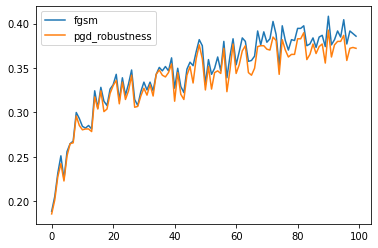

In [5]:
model.train_stats.plot(y=['fgsm','pgd_robustness'])

In [ ]:
train_stats = model.fit_fast(train_loader, test_loader, 100, device)

In [4]:
def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

def _fit_fast(model, train_loader, val_loader , epochs, device, eps = 8/255, patience=None, evaluate_robustness=False):
    #mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
    #mean = torch.tensor(mean).view(3,1,1).expand(3,32,32).to(device)
    #std = torch.tensor(std).view(3,1,1).expand(3,32,32).to(device)
    cifar10_mean = (0,0,0)
    cifar10_std = (1,1,1)

    mu = torch.tensor(cifar10_mean).view(3,1,1).cuda()
    std = torch.tensor(cifar10_std).view(3,1,1).cuda()

    upper_limit = ((1 - mu)/ std)
    lower_limit = ((0 - mu)/ std)
    if model.optim == None:
        #optimizer = optim.Adam(model.parameters(), lr=5e-4)
        optimizer = optim.SGD(model.parameters(),lr=.2, momentum=.9, weight_decay=5e-4)
        lr_steps = epochs * len(train_loader)
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0., max_lr=0.2,
            step_size_up=lr_steps / 2, step_size_down=lr_steps / 2)
    else:
        optimizer = model.optim
    criterion = nn.CrossEntropyLoss().to(device)
    
    epochs_trained = 0
    total_time = 0
    train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = [], [], [], []
    for epoch in range(epochs):
        t0 = time.time()
        running_loss, acc_epoch_loss, avg_epoch_loss, epoch_accuracy, acc_epoch_accuracy = 0.0, 0.0, 0.0, 0.0, 0.0
        
        for i, data in enumerate(train_loader):
            if i==i:
                model.train()
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                #pert = torch.zeros_like(inputs).uniform_(-eps, eps)
                #pert.requires_grad = True
                #adv_inputs = inputs + pert
                #adv_inputs.clamp_(0, 1.0)

                
                
                pert = torch.zeros_like(inputs).uniform_(-eps, eps)
                
                pert.requires_grad = True
                #pert.retain_grad()
                #pert = (inputs+pert).clamp_(0, 1.0) - inputs
                #adv_inputs = 
                
                pert.retain_grad()
                #adv_inputs.sub_(mean).div_(std)
                #clip 0,1

                # first backwards pass to perform fgsm
                outputs = model(inputs + pert)
                
                loss = criterion(outputs, labels)
                
                
                optimizer.zero_grad()
                loss.backward()#(retain_graph=True)
                grad = pert.grad.detach()
                #pert.retain_grad()
                alpha = 1.25*eps
                pert = pert + alpha * grad
                pert.clamp_(-eps, eps)
                pert.data = clamp(pert, lower_limit-inputs, upper_limit-inputs)
                pert = pert.detach()
                
                #pert = (inputs + pert).clamp_(0,1)-inputs
                #adv_inputs = inputs + pert

                # second backwards pass to update weights on adv.
                optimizer.zero_grad()
                outputs = model(inputs+pert)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()
                model.eval()
                clean_outputs = model(inputs)
                clean_train_accuracy = get_accuracy(labels, clean_outputs)
                adv_train_accuracy = get_accuracy(labels, outputs)
                acc_epoch_loss += loss.item() 
                avg_epoch_loss = acc_epoch_loss / (i+1)
                acc_epoch_accuracy += adv_train_accuracy
                avg_epoch_accuracy = acc_epoch_accuracy / (i+1)
                if i%5 == 0:
                    print('[%d, %5d] loss: %.5f, adv_train_accuracy: %.2f, clean_train_accuracy : %.2f' %(epoch + 1, i + 1, loss.item(), adv_train_accuracy, clean_train_accuracy))
        f_adv, f_success = FGSM(model, val_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
        print('fgsm robustness:',1-f_success)
        p_adv, p_success = PGD(model, val_loader, torch.nn.CrossEntropyLoss(), device)
        print('pgd robustness:', 1-p_success)
        lr = scheduler.get_last_lr()[0]
        print('lr:', lr)
        t1 = time.time()
        total_time += t1 - t0
        accuracy, loss = _evaluate_model(model, val_loader, device, criterion)

        print('duration: %d s - train loss: %.5f - train accuracy: %.2f - validation loss: %.5f - validation accuracy: %.2f ' %(t1-t0, avg_epoch_loss, avg_epoch_accuracy, loss, accuracy))
        train_loss_hist.append(avg_epoch_loss)
        train_acc_hist.append(avg_epoch_accuracy)
        val_loss_hist.append(loss)
        val_acc_hist.append(accuracy)
        data = {
            'epoch': epoch+1,
            'train_loss':avg_epoch_loss, 
            'train_accuracy':avg_epoch_accuracy,
            'validation_loss':loss,
            'validation_accuracy':accuracy,
            'duration':total_time,
            'criterion':criterion,
            'optimizer':optimizer,
            'method': 'standard',
            'batchsize': len(next(iter(train_loader))[1]),
            'fgsm': 1-f_success,
            'pgd_robustness': 1-p_success,
        }
        del f_adv
        del f_success
        del p_adv
        del p_success
        model.train_stats = model.train_stats.append(data, ignore_index=True)
        
        if patience != None and patience < epoch and stop_early(val_loss_hist, patience) == True:
            print('stopped early after', patience, 'epochs without decrease of validation loss')
            epochs_trained = i + 1
            break
    model.optim = optimizer
    print('Finished Training')
    return model.train_stats

In [7]:
_fit_fast(model,train_loader, test_loader, 15, device)

[1,     1] loss: 2.78139, adv_train_accuracy: 7.81, clean_train_accuracy : 11.72
[1,     6] loss: 2.48191, adv_train_accuracy: 7.81, clean_train_accuracy : 7.03
[1,    11] loss: 2.77308, adv_train_accuracy: 6.25, clean_train_accuracy : 8.59
[1,    16] loss: 2.32480, adv_train_accuracy: 15.62, clean_train_accuracy : 15.62
[1,    21] loss: 2.24676, adv_train_accuracy: 14.06, clean_train_accuracy : 18.75
[1,    26] loss: 2.23920, adv_train_accuracy: 23.44, clean_train_accuracy : 31.25
[1,    31] loss: 2.58500, adv_train_accuracy: 15.62, clean_train_accuracy : 21.09
[1,    36] loss: 2.20953, adv_train_accuracy: 28.12, clean_train_accuracy : 26.56
[1,    41] loss: 1.91469, adv_train_accuracy: 35.94, clean_train_accuracy : 24.22
[1,    46] loss: 2.05932, adv_train_accuracy: 27.34, clean_train_accuracy : 30.47
[1,    51] loss: 2.01399, adv_train_accuracy: 31.25, clean_train_accuracy : 28.12
[1,    56] loss: 2.15746, adv_train_accuracy: 32.03, clean_train_accuracy : 38.28
[1,    61] loss: 2.06

[2,    96] loss: 1.28991, adv_train_accuracy: 53.12, clean_train_accuracy : 15.62
[2,   101] loss: 1.43567, adv_train_accuracy: 54.69, clean_train_accuracy : 37.50
[2,   106] loss: 1.43302, adv_train_accuracy: 46.88, clean_train_accuracy : 55.47
[2,   111] loss: 1.17550, adv_train_accuracy: 60.16, clean_train_accuracy : 53.91
[2,   116] loss: 1.24559, adv_train_accuracy: 50.78, clean_train_accuracy : 56.25
[2,   121] loss: 1.29171, adv_train_accuracy: 50.00, clean_train_accuracy : 62.50
[2,   126] loss: 1.09037, adv_train_accuracy: 58.59, clean_train_accuracy : 58.59
[2,   131] loss: 1.38396, adv_train_accuracy: 46.88, clean_train_accuracy : 46.88
[2,   136] loss: 1.36397, adv_train_accuracy: 50.78, clean_train_accuracy : 57.81
[2,   141] loss: 1.28525, adv_train_accuracy: 52.34, clean_train_accuracy : 54.69
[2,   146] loss: 1.24874, adv_train_accuracy: 53.12, clean_train_accuracy : 51.56
[2,   151] loss: 1.17600, adv_train_accuracy: 59.38, clean_train_accuracy : 46.09
[2,   156] loss:

[3,   191] loss: 1.10574, adv_train_accuracy: 64.06, clean_train_accuracy : 57.81
[3,   196] loss: 1.43485, adv_train_accuracy: 55.47, clean_train_accuracy : 67.97
[3,   201] loss: 1.21681, adv_train_accuracy: 61.72, clean_train_accuracy : 60.94
[3,   206] loss: 1.08390, adv_train_accuracy: 60.16, clean_train_accuracy : 70.31
[3,   211] loss: 1.05694, adv_train_accuracy: 63.28, clean_train_accuracy : 51.56
[3,   216] loss: 1.03454, adv_train_accuracy: 66.41, clean_train_accuracy : 64.06
[3,   221] loss: 1.13498, adv_train_accuracy: 61.72, clean_train_accuracy : 58.59
[3,   226] loss: 0.98827, adv_train_accuracy: 63.28, clean_train_accuracy : 50.00
[3,   231] loss: 1.20132, adv_train_accuracy: 57.81, clean_train_accuracy : 66.41
[3,   236] loss: 0.82442, adv_train_accuracy: 71.09, clean_train_accuracy : 62.50
[3,   241] loss: 0.86901, adv_train_accuracy: 67.97, clean_train_accuracy : 74.22
[3,   246] loss: 1.08642, adv_train_accuracy: 64.06, clean_train_accuracy : 68.75
[3,   251] loss:

[4,   286] loss: 0.77962, adv_train_accuracy: 75.00, clean_train_accuracy : 72.66
[4,   291] loss: 0.73715, adv_train_accuracy: 78.12, clean_train_accuracy : 82.03
[4,   296] loss: 0.86248, adv_train_accuracy: 71.09, clean_train_accuracy : 70.31
[4,   301] loss: 0.75786, adv_train_accuracy: 71.09, clean_train_accuracy : 63.28
[4,   306] loss: 0.82344, adv_train_accuracy: 76.56, clean_train_accuracy : 73.44
[4,   311] loss: 0.81951, adv_train_accuracy: 71.09, clean_train_accuracy : 76.56
[4,   316] loss: 0.57254, adv_train_accuracy: 82.03, clean_train_accuracy : 76.56
[4,   321] loss: 0.69451, adv_train_accuracy: 70.31, clean_train_accuracy : 73.44
[4,   326] loss: 0.90185, adv_train_accuracy: 73.44, clean_train_accuracy : 78.12
[4,   331] loss: 0.86553, adv_train_accuracy: 71.88, clean_train_accuracy : 72.66
[4,   336] loss: 0.60093, adv_train_accuracy: 75.78, clean_train_accuracy : 74.22
[4,   341] loss: 0.80121, adv_train_accuracy: 71.09, clean_train_accuracy : 75.00
[4,   346] loss:

[5,   381] loss: 0.65345, adv_train_accuracy: 75.00, clean_train_accuracy : 82.81
[5,   386] loss: 0.69822, adv_train_accuracy: 75.78, clean_train_accuracy : 86.72
[5,   391] loss: 0.57670, adv_train_accuracy: 78.75, clean_train_accuracy : 87.50
fgsm robustness: 0.041015625
pgd robustness: 0.0068359375
lr: 0.1333333333333333
duration: 65 s - train loss: 0.75062 - train accuracy: 74.63 - validation loss: 0.74451 - validation accuracy: 75.60 
[6,     1] loss: 0.71843, adv_train_accuracy: 78.12, clean_train_accuracy : 82.81
[6,     6] loss: 0.82632, adv_train_accuracy: 65.62, clean_train_accuracy : 71.09
[6,    11] loss: 0.67169, adv_train_accuracy: 75.00, clean_train_accuracy : 82.81
[6,    16] loss: 0.69970, adv_train_accuracy: 75.00, clean_train_accuracy : 74.22
[6,    21] loss: 0.63024, adv_train_accuracy: 76.56, clean_train_accuracy : 83.59
[6,    26] loss: 0.64237, adv_train_accuracy: 78.91, clean_train_accuracy : 75.78
[6,    31] loss: 0.64649, adv_train_accuracy: 77.34, clean_trai

[7,    71] loss: 0.53224, adv_train_accuracy: 81.25, clean_train_accuracy : 75.78
[7,    76] loss: 0.54945, adv_train_accuracy: 84.38, clean_train_accuracy : 82.03
[7,    81] loss: 0.61828, adv_train_accuracy: 80.47, clean_train_accuracy : 82.03
[7,    86] loss: 0.66472, adv_train_accuracy: 79.69, clean_train_accuracy : 81.25
[7,    91] loss: 0.64466, adv_train_accuracy: 77.34, clean_train_accuracy : 83.59
[7,    96] loss: 0.49663, adv_train_accuracy: 85.16, clean_train_accuracy : 81.25
[7,   101] loss: 0.61403, adv_train_accuracy: 79.69, clean_train_accuracy : 82.03
[7,   106] loss: 0.76854, adv_train_accuracy: 72.66, clean_train_accuracy : 76.56
[7,   111] loss: 0.54855, adv_train_accuracy: 79.69, clean_train_accuracy : 86.72
[7,   116] loss: 0.45578, adv_train_accuracy: 85.16, clean_train_accuracy : 89.06
[7,   121] loss: 0.55830, adv_train_accuracy: 82.03, clean_train_accuracy : 81.25
[7,   126] loss: 0.75390, adv_train_accuracy: 74.22, clean_train_accuracy : 80.47
[7,   131] loss:

[8,   166] loss: 0.54943, adv_train_accuracy: 80.47, clean_train_accuracy : 80.47
[8,   171] loss: 0.80463, adv_train_accuracy: 75.78, clean_train_accuracy : 78.91
[8,   176] loss: 0.59959, adv_train_accuracy: 81.25, clean_train_accuracy : 78.91
[8,   181] loss: 0.65090, adv_train_accuracy: 77.34, clean_train_accuracy : 64.06
[8,   186] loss: 0.81380, adv_train_accuracy: 75.78, clean_train_accuracy : 85.16
[8,   191] loss: 0.65640, adv_train_accuracy: 81.25, clean_train_accuracy : 74.22
[8,   196] loss: 0.68817, adv_train_accuracy: 78.12, clean_train_accuracy : 75.78
[8,   201] loss: 0.52245, adv_train_accuracy: 82.81, clean_train_accuracy : 75.78
[8,   206] loss: 0.40502, adv_train_accuracy: 82.03, clean_train_accuracy : 89.06
[8,   211] loss: 0.58450, adv_train_accuracy: 80.47, clean_train_accuracy : 81.25
[8,   216] loss: 0.55853, adv_train_accuracy: 82.03, clean_train_accuracy : 76.56
[8,   221] loss: 0.76214, adv_train_accuracy: 75.00, clean_train_accuracy : 78.91
[8,   226] loss:

[9,   261] loss: 0.58844, adv_train_accuracy: 81.25, clean_train_accuracy : 87.50
[9,   266] loss: 0.60414, adv_train_accuracy: 78.12, clean_train_accuracy : 82.81
[9,   271] loss: 0.51920, adv_train_accuracy: 84.38, clean_train_accuracy : 90.62
[9,   276] loss: 0.63356, adv_train_accuracy: 79.69, clean_train_accuracy : 74.22
[9,   281] loss: 0.55875, adv_train_accuracy: 80.47, clean_train_accuracy : 87.50
[9,   286] loss: 0.45538, adv_train_accuracy: 86.72, clean_train_accuracy : 78.12
[9,   291] loss: 0.62728, adv_train_accuracy: 78.12, clean_train_accuracy : 29.69
[9,   296] loss: 0.60193, adv_train_accuracy: 79.69, clean_train_accuracy : 80.47
[9,   301] loss: 0.51561, adv_train_accuracy: 82.03, clean_train_accuracy : 89.84
[9,   306] loss: 0.65840, adv_train_accuracy: 78.12, clean_train_accuracy : 82.81
[9,   311] loss: 0.54504, adv_train_accuracy: 84.38, clean_train_accuracy : 89.06
[9,   316] loss: 0.54034, adv_train_accuracy: 82.03, clean_train_accuracy : 88.28
[9,   321] loss:

[10,   351] loss: 0.41173, adv_train_accuracy: 87.50, clean_train_accuracy : 84.38
[10,   356] loss: 0.51098, adv_train_accuracy: 83.59, clean_train_accuracy : 79.69
[10,   361] loss: 0.41955, adv_train_accuracy: 79.69, clean_train_accuracy : 85.94
[10,   366] loss: 0.61929, adv_train_accuracy: 80.47, clean_train_accuracy : 85.16
[10,   371] loss: 0.37295, adv_train_accuracy: 84.38, clean_train_accuracy : 89.84
[10,   376] loss: 0.38513, adv_train_accuracy: 85.94, clean_train_accuracy : 92.97
[10,   381] loss: 0.45373, adv_train_accuracy: 83.59, clean_train_accuracy : 89.84
[10,   386] loss: 0.49876, adv_train_accuracy: 82.81, clean_train_accuracy : 88.28
[10,   391] loss: 0.54701, adv_train_accuracy: 80.00, clean_train_accuracy : 90.00
fgsm robustness: 0.033203125
pgd robustness: 0.001953125
lr: 0.1333333333333334
duration: 65 s - train loss: 0.49189 - train accuracy: 83.28 - validation loss: 0.58592 - validation accuracy: 80.56 
[11,     1] loss: 0.41248, adv_train_accuracy: 86.72, c

[12,    31] loss: 0.35484, adv_train_accuracy: 88.28, clean_train_accuracy : 89.06
[12,    36] loss: 0.36725, adv_train_accuracy: 89.06, clean_train_accuracy : 88.28
[12,    41] loss: 0.44347, adv_train_accuracy: 84.38, clean_train_accuracy : 90.62
[12,    46] loss: 0.36718, adv_train_accuracy: 84.38, clean_train_accuracy : 86.72
[12,    51] loss: 0.28004, adv_train_accuracy: 92.19, clean_train_accuracy : 87.50
[12,    56] loss: 0.40960, adv_train_accuracy: 85.94, clean_train_accuracy : 85.16
[12,    61] loss: 0.45174, adv_train_accuracy: 84.38, clean_train_accuracy : 85.16
[12,    66] loss: 0.40839, adv_train_accuracy: 84.38, clean_train_accuracy : 93.75
[12,    71] loss: 0.28057, adv_train_accuracy: 92.19, clean_train_accuracy : 91.41
[12,    76] loss: 0.42196, adv_train_accuracy: 86.72, clean_train_accuracy : 83.59
[12,    81] loss: 0.36596, adv_train_accuracy: 88.28, clean_train_accuracy : 88.28
[12,    86] loss: 0.33252, adv_train_accuracy: 85.94, clean_train_accuracy : 86.72
[12,

[13,   121] loss: 0.39862, adv_train_accuracy: 85.94, clean_train_accuracy : 89.84
[13,   126] loss: 0.48759, adv_train_accuracy: 82.03, clean_train_accuracy : 83.59
[13,   131] loss: 0.45906, adv_train_accuracy: 82.81, clean_train_accuracy : 90.62
[13,   136] loss: 0.32585, adv_train_accuracy: 89.06, clean_train_accuracy : 91.41
[13,   141] loss: 0.33423, adv_train_accuracy: 89.06, clean_train_accuracy : 93.75
[13,   146] loss: 0.39168, adv_train_accuracy: 87.50, clean_train_accuracy : 86.72
[13,   151] loss: 0.38105, adv_train_accuracy: 87.50, clean_train_accuracy : 90.62
[13,   156] loss: 0.33783, adv_train_accuracy: 86.72, clean_train_accuracy : 89.06
[13,   161] loss: 0.31573, adv_train_accuracy: 89.06, clean_train_accuracy : 92.97
[13,   166] loss: 0.30563, adv_train_accuracy: 89.06, clean_train_accuracy : 91.41
[13,   171] loss: 0.33995, adv_train_accuracy: 91.41, clean_train_accuracy : 89.06
[13,   176] loss: 0.34666, adv_train_accuracy: 85.16, clean_train_accuracy : 89.06
[13,

[14,   211] loss: 0.17282, adv_train_accuracy: 94.53, clean_train_accuracy : 93.75
[14,   216] loss: 0.34040, adv_train_accuracy: 87.50, clean_train_accuracy : 88.28
[14,   221] loss: 0.30975, adv_train_accuracy: 88.28, clean_train_accuracy : 92.97
[14,   226] loss: 0.47915, adv_train_accuracy: 82.03, clean_train_accuracy : 91.41
[14,   231] loss: 0.22996, adv_train_accuracy: 94.53, clean_train_accuracy : 95.31
[14,   236] loss: 0.17089, adv_train_accuracy: 92.97, clean_train_accuracy : 94.53
[14,   241] loss: 0.35344, adv_train_accuracy: 85.16, clean_train_accuracy : 92.97
[14,   246] loss: 0.32335, adv_train_accuracy: 87.50, clean_train_accuracy : 91.41
[14,   251] loss: 0.18892, adv_train_accuracy: 93.75, clean_train_accuracy : 95.31
[14,   256] loss: 0.15819, adv_train_accuracy: 94.53, clean_train_accuracy : 96.09
[14,   261] loss: 0.23297, adv_train_accuracy: 92.97, clean_train_accuracy : 95.31
[14,   266] loss: 0.24238, adv_train_accuracy: 90.62, clean_train_accuracy : 92.19
[14,

[15,   301] loss: 0.11581, adv_train_accuracy: 97.66, clean_train_accuracy : 98.44
[15,   306] loss: 0.12328, adv_train_accuracy: 96.88, clean_train_accuracy : 97.66
[15,   311] loss: 0.13023, adv_train_accuracy: 95.31, clean_train_accuracy : 95.31
[15,   316] loss: 0.08592, adv_train_accuracy: 97.66, clean_train_accuracy : 97.66
[15,   321] loss: 0.12309, adv_train_accuracy: 96.09, clean_train_accuracy : 97.66
[15,   326] loss: 0.12210, adv_train_accuracy: 96.09, clean_train_accuracy : 97.66
[15,   331] loss: 0.14606, adv_train_accuracy: 95.31, clean_train_accuracy : 96.88
[15,   336] loss: 0.17445, adv_train_accuracy: 93.75, clean_train_accuracy : 94.53
[15,   341] loss: 0.13293, adv_train_accuracy: 94.53, clean_train_accuracy : 95.31
[15,   346] loss: 0.29591, adv_train_accuracy: 89.06, clean_train_accuracy : 93.75
[15,   351] loss: 0.17137, adv_train_accuracy: 95.31, clean_train_accuracy : 95.31
[15,   356] loss: 0.22096, adv_train_accuracy: 90.62, clean_train_accuracy : 95.31
[15,

,epoch,train_loss,train_accuracy,validation_loss,l_inf_robustness,l_inf_loss,l_2_robustness,l_2_loss,l_0_robustness,l_0_loss,validation_accuracy,duration,criterion,optimizer,method,learning_rate,batchsize,fgsm,pgd_robustness
0,1,1.735074,38.615329,2.059973,NaN,NaN,NaN,NaN,NaN,NaN,37.84,65.838798,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,standard,NaN,128,0.038086,0.010742
1,2,1.238846,56.209239,2.117689,NaN,NaN,NaN,NaN,NaN,NaN,39.29,131.683004,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,standard,NaN,128,0.018555,0.013672
2,3,1.078297,63.611333,1.001149,NaN,NaN,NaN,NaN,NaN,NaN,65.61,197.551691,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,standard,NaN,128,0.063477,0.033203
3,4,0.849258,71.118526,0.926079,NaN,NaN,NaN,NaN,NaN,NaN,71.63,263.375225,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,standard,NaN,128,0.051758,0.012695
4,5,0.750622,74.625959,0.744509,NaN,NaN,NaN,NaN,NaN,NaN,75.60,329.245767,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,standard,NaN,128,0.041016,0.006836
5,6,0.668743,77.207880,0.701458,NaN,NaN,NaN,NaN,NaN,NaN,76.12,395.172858,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,standard,NaN,128,0.019531,0.002930
6,7,0.624516,78.899457,0.741947,NaN,NaN,NaN,NaN,NaN,NaN,75.56,461.113792,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,standard,NaN,128,0.020508,0.000000
7,8,0.582962,80.212596,0.717935,NaN,NaN,NaN,NaN,NaN,NaN,76.48,527.081791,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,standard,NaN,128,0.040039,0.000977
8,9,0.528952,82.028453,0.566023,NaN,NaN,NaN,NaN,NaN,NaN,81.23,593.022491,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,standard,NaN,128,0.039062,0.006836
9,10,0.491886,83.282848,0.585915,NaN,NaN,NaN,NaN,NaN,NaN,80.56,659.000379,CrossEntropyLoss(),SGD (\nParameter Group 0\n dampening: 0\n ...,standard,NaN,128,0.033203,0.001953


In [6]:
def get_accuracy(labels, outputs):
    _, predicted = torch.max(outputs.data, 1)

    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return 100 * correct / total

def fgsm(gradients, step_size=.05):
    return step_size*torch.sign(gradients)

def stop_early(val_loss_hist, patience):
    return len(list(filter(lambda x: val_loss_hist[-patience-1] > x, val_loss_hist[-(patience):]))) == 0 # Check if any value in the last x-1 epochs is higher then the value of the epoch t-x 


def PGD(model, data_loader, criterion, device, max_stepsize=1.25*8/255, eps=8/255, steps=7):
    model.eval()
    advs = []
    correct = 0
    total = 0
    for i, data in enumerate(data_loader):
        if i < 8:
            inputs, labels = data
            inputs, labels =inputs.to(device), labels.to(device)

            adv_examples = inputs
            adv_examples.requires_grad = True
            adv_examples.retain_grad()
            for step in range(steps):
                #print(torch.max(adv_examples[0]-inputs[0][0]))
                adv_examples, pert = FGSM_step(model, adv_examples, labels, criterion, max_stepsize, device)
                pert = adv_examples - inputs
                pert.clamp_(-eps, eps)
                adv_examples = inputs + pert
                adv_examples.clamp_(0,1)
            advs.append(adv_examples)
            preds = model(adv_examples)
            #pred_labels = 
            _, predicted = torch.max(preds.data, 1)
            total += len(predicted)
            #correct += (pred_labels == labels).sum().item()
            correct += (predicted != labels).sum().item()
    return advs, correct/total
        

def FGSM_step(model, inputs, labels, criterion, eps, device):

    inputs.retain_grad()
    perturbation = torch.zeros_like(inputs).to(device)
    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward(retain_graph=True)
    perturbation = torch.sign(inputs.grad).clamp_(-eps, eps)
    adv_examples = inputs + perturbation
    adv_examples.clamp_(0,1)
    return adv_examples, perturbation
    

def FGSM(model, data_loader, criterion, eps, device):
    model.eval()
    #mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
    #mean = torch.tensor(mean).view(3,1,1).expand(3,32,32).to(device)
    #std = torch.tensor(std).view(3,1,1).expand(3,32,32).to(device)
    advs = []
    correct = 0
    total = 0
    for i,data in enumerate(data_loader):
        if i < 8:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs.requires_grad = True
            adv_examples, perturbation = FGSM_step(model, inputs, labels, criterion, eps, device)

            advs.append(adv_examples)
            preds = model(adv_examples)
            #pred_labels = 
            _, predicted = torch.max(preds.data, 1)
            total += len(predicted)
            #correct += (pred_labels == labels).sum().item()
            correct += (predicted != labels).sum().item()

    
    return advs, correct/total

In [ ]:
PATH = './saved-models/cifar-resnet-fast-100-epochs.pth'
torch.save({
        'epoch': 100,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [ ]:
train_stats1 = model.fit_fast(train_loader, test_loader, 100, device)

In [ ]:
PATH = './saved-models/cifar-resnet-fast-200-epochs.pth'
torch.save({
        'epoch': 200,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [ ]:
train_stats2 = model.fit_fast(train_loader, test_loader, 100, device)

In [ ]:
PATH = './saved-models/cifar-resnet-fast-300-epochs.pth'
torch.save({
        'epoch': 300,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [ ]:
train_stats3 = model.fit_fast(train_loader, test_loader, 100, device)

In [ ]:
PATH = './saved-models/cifar-resnet-fast-400-epochs.pth'
torch.save({
        'epoch': 400,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [ ]:
train_stats4 = model.fit_fast(train_loader, test_loader, 100, device)

In [ ]:
PATH = './saved-models/cifar-resnet-fast-500-epochs.pth'
torch.save({
        'epoch': 500,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [ ]:
train_stats5 = model.fit_fast(train_loader, test_loader, 100, device)

In [ ]:
PATH = './saved-models/cifar-resnet-fast-600-epochs.pth'
torch.save({
        'epoch': 600,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [ ]:
train_stats3 = model.fit_fast(train_loader, test_loader, 100, device)

In [ ]:
PATH = './saved-models/cifar-resnet-fast-700-epochs.pth'
torch.save({
        'epoch': 700,
        'model_state_dict': model.state_dict(),
        }, PATH)

In [ ]:
checkpoint = torch.load('./saved-models/cifar-resnet-fast-100-epochs.pth')
checkpoint

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
evaluate_clean_accuracy(model,test_loader, device)

In [ ]:
x = next(iter(test_loader))[0][1]
plt.imshow(x.T)

In [ ]:
f = f_adv[0][1].cpu().detach()
plt.imshow(f.T)

In [ ]:
p = p_adv[0][1].cpu().detach()
plt.imshow(p.T)

In [ ]:
torch.max(x - f)

In [ ]:
torch.min(x - p)

In [ ]:
7*2/255

In [ ]:
f_adv, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

In [ ]:
p_adv, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

In [ ]:
fmodel = PyTorchModel(model, bounds=(0, 1))
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)


In [ ]:
clean_acc = accuracy(fmodel, images, labels)
print(f"clean accuracy:  {clean_acc * 100:.1f} %")

In [ ]:
attack = FGSM()
epsilon = 8/255
raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilon)

In [ ]:
robust_accuracy = 1 - success.float().mean(axis=-1)

In [ ]:
robust_accuracy

In [ ]:
train_stats = model.fit_fast(train_loader, test_loader, 10, device, patience=10)

In [ ]:
_, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

In [ ]:
_, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

In [ ]:
train_stats = model.fit_fast(train_loader, test_loader, 10, device, patience=10)

In [ ]:
_, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

In [ ]:
_, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

In [ ]:
train_stats = model.fit_fast(train_loader, test_loader, 10, device, patience=10)

In [ ]:
_, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

In [ ]:
_, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

In [ ]:
train_stats = model.fit_fast(train_loader, test_loader, 10, device, patience=10)

In [ ]:
_, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

In [ ]:
_, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

In [ ]:

import torch.nn.functional as F
from torch import clamp

criterion = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

alpha=10

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

mu = torch.tensor(cifar10_mean).view(3,1,1).cuda()
std = torch.tensor(cifar10_std).view(3,1,1).cuda()

upper_limit = ((1 - mu)/ std)
lower_limit = ((0 - mu)/ std)

def loc_train(model, epochs, epsilon):
    for epoch in range(epochs):
        start_epoch_time = time.time()
        train_loss = 0
        train_acc = 0
        train_n = 0
        for i, (X, y) in enumerate(train_loader):
            X, y = X.cuda(), y.cuda()
            if i == 0:
                first_batch = (X, y)
            delta = torch.zeros_like(X).cuda()
            

            delta.uniform_(-epsilon, epsilon)
            delta.data = clamp(delta, 0,1)
            
            delta.requires_grad = True
            output = model(X + delta[:X.size(0)])
            loss = F.cross_entropy(output, y)
            loss.backward()
            grad = delta.grad.detach()
            delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
            delta.data[:X.size(0)] = clamp(delta[:X.size(0)], 0,1)
            delta = delta.detach()
            output = model(X + delta[:X.size(0)])
            loss = criterion(output, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item() * y.size(0)
            train_acc += (output.max(1)[1] == y).sum().item()
            train_n += y.size(0)
            print(train_acc/train_n, train_loss/train_n)
        epoch_time = time.time()
    return model


In [ ]:
model = loc_train(model, 10, 8/255)

In [ ]:
evaluate_clean_accuracy(model, test_loader, device)

In [ ]:
_, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 8/255, device)
success

In [ ]:
_, success = PGD(model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device)
success

In [ ]:
model, data_loader, criterion, steps, max_stepsize, eps, device = model, test_loader, torch.nn.CrossEntropyLoss(), 7, 2/255, 8/255, device

model.eval()
advs = []
correct = 0
total = 0
for i, data in enumerate(data_loader):
    print(i)
    if i==0:
        inputs, labels = data
        inputs, labels =inputs.to(device), labels.to(device)
        adv_examples = inputs
        #adv_inputs = inputs
        adv_examples.requires_grad = True
        #perturbation = torch.zeros_like(adv_inputs, requires_grad=True).to(device)
        for step in range(steps):

            perturbation = torch.zeros_like(inputs, requires_grad=True).to(device)
            preds = model(adv_examples)
            loss = criterion(preds, labels)
            adv_examples.retain_grad()
            loss.backward()

            perturbation = torch.sign(adv_examples.grad).clamp_(-eps, eps)
            print(inputs)
            adv_examples = adv_examples + perturbation
            #adv_examples, pert = FGSM_step(model, adv_examples, labels, criterion, max_stepsize, device)
            adv_examples.clamp_(-eps, eps)

        advs.append(adv_examples)


